# Computer Network Anomaly Detection Utilizing Restricted Boltzmann Machines And Discriminative Regression

## Thesis 2019
### Andrew William Reynolds Gold

This is the Jupyter Notebook containing all of the data preprocessing steps and experiments for my thesis. The CICIDS2017 dataset can be downloaded at the following link:

- https://iscxdownloads.cs.unb.ca/iscxdownloads/CIC-IDS-2017/MachineLearningCSV.zip

There are a total of 8 datasets:

- 1 Monday dataset (benign traffic only)
- 1 Tuesday dataset (benign and brute force)
- 1 Wednesday dataset (benign, DoS, and Heartbleed)
- 2 Thursday datasets (benign, web attack, and infiltration)
- 3 Friday datasets (benign, DDoS, portscan, and botnet)

---

### Preprocessing Steps:
Please see the full thesis writeup for data processing steps.

1. The 8 datasets are combined into a single Pandas dataframe.
1. The dataframe is then purged of examples with missing class labels, null, or infinite values.
1. A duplicate column is removed (occurs somehow during the combination process in Pandas)
1. Indices are reset
1. Dataframe target labels are separated and encoded into 3 separate vectors:
    1. Binary classification (0,1 target labels) -> df_bin_etc
    1. Meta-class classification (0-6 target labels) -> df_meta_etc
    1. Multi-class classification (0-14 target labels) -> df_full_etc
1. The dataframe (minus the target label vector) is normalized between 0 and 1 using SK-learn's MinMaxScaler()
1. The dataframe is copied thrice, with each of the target vectors appended back to the dataset, according to the 3 types of target labels listed above.

---

### Experiment Design:

The following steps are applied identically to each of the 3 datasets:

1. 50% of the benign data is separated and preprocessed in isolation from the other datasets. This is done to prevent the model from witnessing the same benign examples from training in testing and validation, which would likely result in a higher classification accuracy.
1. The data is duplicated into 5 groups. The first 4 using SK-learn's StratifiedShuffleSplit(), being stratified to ensure proportional distribution across the training, testing, and validation sets:
    1. **Benign** [df_benign]
        1. Training (80% of the benign dataset) [df_benign_train]
        1. Testing (20% of the benign dataset) [df_benign_test]
        1. Validation* (20% of the training dataset) [df_benign_train_val]
    1. **Binary Classification** [df_bin]
        1. Training (80% of the full binary encoded dataset, including malicious traffic) [df_bin_train]
        1. Testing (20% of the full binary encoded dataset, including malicious traffic) [df_bin_test]
        1. Validation* (20% of the full binary encoded training dataset, including malicious traffic) [df_bin_train_val]
    1. **Meta-class classification** [df_meta]
        1. Training (80% of the full meta-class encoded dataset, including malicious traffic) [df_meta_train]
        1. Testing (20% of the full meta-class encoded dataset, including malicious traffic) [df_meta_test]
        1. Validation* (20% of the full meta-class encoded training dataset, including malicious traffic) [df_meta_train_val]
    1. **Multi-class classification** [df_full]
        1. Training (80% of the full multi-class encoded dataset, including malicious traffic) [df_full_train]
        1. Testing (20% of the full multi-class encoded dataset, including malicious traffic) [df_full_test]
        1. Validation* (20% of the full multi-class encoded training dataset, including malicious traffic) [df_full_train_val]
1. The 5th is a balanced binary dataset, ensuring that the training, testing, and validation sets therein each contain 50% benign traffic and 50% malicious traffic. However, the subclasses of malicious traffic are not balanced as such, and are of the same distribution across all subclasses as the original dataset. 
    1. **Balanced Binary Classification** [df_bal_bin]
        1. Training (80% of the benign dataset) [df_bal_bin_train]
        1. Testing (20% of the benign dataset) [df_bal_bin_test]
        1. Validation* (20% of the benign training dataset) [df_bal_bin_train_val]
        

\* **If you're wondering why the validation set is constructed from the training set, it is for these reasons**:

* During 5-fold grid search cross validation, the training set is again stratified, shuffled, and split into a 80% *...train_train* set, and 20% a *...train_val* set. This means that during cross validation of the model parameters, there is no data leakage. 
* This allows us to recombine the *...train_train* and *...train_val* set after cross validation back into the df_train dataset, allowing the model more examples to learn from without affecting the performance (remember it's been trained and validated on separate sets). 


---
# Dependencies

In [1]:
import os
import tarfile
import csv
import numpy as np
import pandas as pd
import sys
from pathlib import Path
import sklearn as skl
# import multiprocessing
import binascii
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import *

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from scipy.ndimage import convolve
import gc


from sklearn.neural_network import BernoulliRBM
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc


## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))


# Dataset

Be sure to set the first line to the download location of the dataset on your machine:

In [5]:
# Be sure to set this to your download location, or the location of the CICIDS2017 dataset folder
data_folder = Path('C:/Users/awrgo/Desktop/Projects/Thesis/Data/MachineLearningCSV/MachineLearningCVE/')

# Read each of the datasets into a dataframe
df_monday_full = pd.read_csv(data_folder / "Monday-WorkingHours.pcap_ISCX.csv", low_memory=False, comment='#', na_values=[""])
df_tuesday_full = df_raw = pd.read_csv(data_folder / "Tuesday-WorkingHours.pcap_ISCX.csv", low_memory=False, comment='#', na_values=[""])
df_wednesday_full = pd.read_csv(data_folder / "Wednesday-workingHours.pcap_ISCX.csv", low_memory=False, comment='#', na_values=[""])
df_thurs_morn = pd.read_csv(data_folder / "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv", low_memory=False, comment='#', na_values=[""])
df_thurs_aft = pd.read_csv(data_folder / "Thursday-WorkingHours-Afternoon-Infiltration.pcap_ISCX.csv", low_memory=False, comment='#', na_values=[""])
df_fri_morn = pd.read_csv(data_folder / "Friday-WorkingHours-Morning.pcap_ISCX.csv", low_memory=False, comment='#', na_values=[""])
df_fri_aft_1 = pd.read_csv(data_folder / "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", low_memory=False, comment='#', na_values=[""])
df_fri_aft_2 = pd.read_csv(data_folder / "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory=False, comment='#', na_values=[""])

# Strip the empty spaces from the beginning of the columns
df_monday_full.columns = df_monday_full.columns.str.strip()
df_tuesday_full.columns = df_tuesday_full.columns.str.strip()
df_wednesday_full.columns = df_wednesday_full.columns.str.strip()
df_thurs_morn.columns = df_thurs_morn.columns.str.strip()
df_thurs_aft.columns = df_thurs_aft.columns.str.strip()
df_fri_morn.columns = df_fri_morn.columns.str.strip()
df_fri_aft_1.columns = df_fri_aft_1.columns.str.strip()
df_fri_aft_2.columns = df_fri_aft_2.columns.str.strip()

# Concatenate all of the separate datasets into one full dataset
frames = [df_monday_full, df_tuesday_full, df_wednesday_full, df_thurs_morn, df_thurs_aft, df_fri_morn, df_fri_aft_1, df_fri_aft_2]
df_raw = pd.concat(frames, ignore_index=False, copy=False)



Remove spaces and special characters and replace with underscores. Convert numeric string values to float values:

In [6]:
df_raw['Flow Bytes/s'] = df_raw['Flow Bytes/s'].astype('float64')
df_raw['Flow Packets/s'] = df_raw['Flow Packets/s'].astype('float64')

df_raw.columns = df_raw.columns.str.replace(' ', '_')
df_raw.columns = df_raw.columns.str.replace('/s', '_per_sec')
df_raw.columns = df_raw.columns.str.replace('/Bulk', '_Bulk')



Drop examples with null or infinite values, and the duplicate column 'Fwd_Header_Length.1':

In [7]:
df_raw.dropna(axis=0, inplace=True)
df_raw.drop('Fwd_Header_Length.1', axis=1, inplace=True)

# get rid of the infinities and null values
df_raw = df_raw[df_raw != np.inf]
df_raw.dropna(inplace=True)

# And reset the indices because dropping rows leads to problems
df_raw.reset_index(drop=True, inplace=True)


Convert back into a CSV file. It is recommended to restart the notebook and start again from the line below, or use the garbage collector to free up memory, as the following can easily consume 16GB of RAM:

In [ ]:
df_raw.to_csv("C:/Users/awrgo/Desktop/Projects/Thesis/Data/df_fully_combined")

Uncomment the following line to manually use garbage collector to free up memory (may not be enough, depending on your environment):

In [311]:
gc.collect()

59503

---
---
---

# Data Cleaning:

Data cleaning in preparation for experiments:

In [4]:
df_clean = pd.read_csv('C:/Users/awrgo/Desktop/Projects/Datasets/Bachelor Thesis/df_fully_combined', 
                        low_memory=False, comment='#', na_values=[""])

# An extra empty column gets added for whatever reason, drop it:
df_clean.drop('Unnamed: 0', axis=1, inplace=True)

# Normalize the Data

Here we normalize the data (excluding the target labels) to continuous values between 0-1. This is done early, as we need to later separate the data into various dataframes for experiments, and first we need to ensure that a set of benign data that the RBM will be trained on will never be seen in testing data:

In [5]:
scaler = MinMaxScaler()

clean_labels = df_clean.Label
df_clean_temp = pd.DataFrame(scaler.fit_transform(df_clean.drop('Label', axis=1, inplace=False)))

df_clean_temp['Label'] = clean_labels
df_clean_temp.columns = df_clean.columns

df_clean = df_clean_temp

# Check to make sure it worked:
df_clean.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,0.750561,1.416667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,0.755108,1.333333e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [6]:
df_clean.Label.value_counts()

BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

### Separate the malicious into individual DataFrames
Get all individual types of malicious data

In [7]:
mal_FTP_Pat = pd.DataFrame(df_clean[df_clean.Label == 'FTP-Patator'].drop('Label', axis=1, inplace=False))
mal_SSH_Pat = pd.DataFrame(df_clean[df_clean.Label == 'SSH-Patator'].drop('Label', axis=1, inplace=False))
mal_DOS_Slowloris = pd.DataFrame(df_clean[df_clean.Label == 'DoS slowloris'].drop('Label', axis=1, inplace=False))
mal_DOS_Slowhttptest = pd.DataFrame(df_clean[df_clean.Label == 'DoS Slowhttptest'].drop('Label', axis=1, inplace=False))
mal_DOS_Hulk = pd.DataFrame(df_clean[df_clean.Label == 'DoS Hulk'].drop('Label', axis=1, inplace=False))
mal_DOS_Goldeneye = pd.DataFrame(df_clean[df_clean.Label == 'DoS GoldenEye'].drop('Label', axis=1, inplace=False))
mal_Heartbleed = pd.DataFrame(df_clean[df_clean.Label == 'Heartbleed'].drop('Label', axis=1, inplace=False))
mal_WEB_BF = pd.DataFrame(df_clean[df_clean.Label == 'Web Attack � Brute Force'].drop('Label', axis=1, inplace=False))
mal_WEB_XSS = pd.DataFrame(df_clean[df_clean.Label == 'Web Attack � XSS'].drop('Label', axis=1, inplace=False))
mal_WEB_SQL = pd.DataFrame(df_clean[df_clean.Label == 'Web Attack � Sql Injection'].drop('Label', axis=1, inplace=False))
mal_Infiltration = pd.DataFrame(df_clean[df_clean.Label == 'Infiltration'].drop('Label', axis=1, inplace=False))
mal_Bot = pd.DataFrame(df_clean[df_clean.Label == 'Bot'].drop('Label', axis=1, inplace=False))
mal_PortScan = pd.DataFrame(df_clean[df_clean.Label == 'PortScan'].drop('Label', axis=1, inplace=False))
mal_DDoS = pd.DataFrame(df_clean[df_clean.Label == 'DDoS'].drop('Label', axis=1, inplace=False))


set_malicious = [mal_FTP_Pat, mal_SSH_Pat, mal_DOS_Slowloris, mal_DOS_Slowhttptest, mal_DOS_Hulk, mal_DOS_Goldeneye,
                 mal_Heartbleed, mal_WEB_BF, mal_WEB_XSS, mal_WEB_SQL, mal_Infiltration, mal_Bot, mal_PortScan, mal_DDoS]

df_malicious = df_clean[df_clean.Label != 'BENIGN']

---
### Create the Benign-only Dataframe:

In [8]:
df_benign = df_clean[df_clean.Label == 'BENIGN']

# df_benign.drop('Label', axis=1, inplace=True)

df_benign.head()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,0.750561,1.416667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,0.750561,1.166667e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,0.755108,1.333333e-07,0.000005,0.0,9.302326e-07,0.0,0.000242,0.002581,0.00101,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


Separate 50% of the benign data for just training the RBM on later.

### df_benign_train will be untouched and will not exist in any of the datasets for training or testing purposes, both on the logistic regression baseline as well as the RBM-based models down the line.** This was done for 2 reasons: 

1. to ensure that absolutely no data leak occurs, such that an RBM trained on df_benign_train will not see the same training examples in testing environments, and
1. re: the exclusion from the logistic regression baseline - I didn't want the baseline logistic regressors to have a larger dataset with more benign examples to learn from, so that they are trained on the exact same datasets as the RBM models.

In [7]:
# split the benign data into half
df_benign_train, df_benign_test = train_test_split(df_benign, test_size=(1/2))


# split df_benign_test in half, so the final benign distribution is 1:1:1
# df_benign_test, df_benign_val = train_test_split(df_benign_test, test_size=0.5)


In [8]:
df_benign_train.sort_index()
df_benign_test.sort_index()
# df_benign_val.sort_index()

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,...,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label
0,0.750561,1.416667e-07,0.000005,0.000000,9.302326e-07,0.000000e+00,0.000242,0.002581,0.001010,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,BENIGN
3,0.750561,1.166667e-07,0.000005,0.000000,9.302326e-07,0.000000e+00,0.000242,0.002581,0.001010,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,BENIGN
4,0.755108,1.333333e-07,0.000005,0.000000,9.302326e-07,0.000000e+00,0.000242,0.002581,0.001010,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,BENIGN
10,0.001343,9.774999e-06,0.000036,0.000021,2.429457e-04,4.650219e-06,0.062530,0.000000,0.058615,0.095779,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,BENIGN
11,0.001343,4.475000e-06,0.000027,0.000014,2.179845e-04,4.302368e-06,0.056285,0.000000,0.067619,0.095419,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,BENIGN
12,0.015778,1.583333e-07,0.000000,0.000003,4.651163e-07,9.153974e-09,0.000242,0.002581,0.001010,0.000000,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,BENIGN
16,0.001343,7.408333e-06,0.000036,0.000014,4.883721e-05,4.488499e-06,0.012087,0.000000,0.011783,0.018303,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,BENIGN
17,0.001343,8.516666e-06,0.000027,0.000014,2.130233e-04,4.241341e-06,0.054996,0.000000,0.066080,0.093227,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,BENIGN
18,0.001343,5.241666e-06,0.000027,0.000014,3.751938e-05,6.316242e-07,0.009388,0.000000,0.011639,0.015713,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,BENIGN
21,0.001343,7.833333e-06,0.000036,0.000021,2.449612e-04,4.668527e-06,0.063054,0.000000,0.059101,0.096583,...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,BENIGN


### Create the Binary-class Dataframe:

In [9]:
df_bin = df_benign.copy()
df_bin = pd.concat([df_bin, df_malicious])

df_bin.Label[df_clean.Label == 'BENIGN'] = 0
df_bin.Label[df_clean.Label != 'BENIGN'] = 1


# Test to make sure it worked (0, 1)
df_bin.Label.value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0    2271320
1     556556
Name: Label, dtype: int64

In [10]:
%time df_bin.to_csv("C:/Users/awrgo/Desktop/Projects/Datasets/Bachelor Thesis/df_benign_binary")

Wall time: 4min 18s


In [11]:
duh = df_bin[:50000].copy()
%time duh.to_csv("C:/Users/awrgo/Desktop/Projects/Datasets/Bachelor Thesis/df_benign_binary_small")

Wall time: 4.59 s


---
### Create the Meta-class Dataframe:

In [10]:
df_meta = df_benign_test.copy()
df_meta = pd.concat([df_meta, df_malicious])


### ------ Manually encode the labels ------


# Benign == 0
df_meta.Label[df_meta.Label == "BENIGN"] = 0

# Brute force == 1
df_meta.Label[df_meta.Label == "SSH-Patator"] = 1
df_meta.Label[df_meta.Label == "FTP-Patator"] = 1

# DDoS/DoS attacks == 2
df_meta.Label[df_meta.Label == "DoS slowloris"] = 2
df_meta.Label[df_meta.Label == "DoS Slowhttptest"] = 2
df_meta.Label[df_meta.Label == "DoS Hulk"] = 2
df_meta.Label[df_meta.Label == "DoS GoldenEye"] = 2
df_meta.Label[df_meta.Label == "DDoS"] = 2

# Heartbleed and Infiltration == 3
df_meta.Label[df_meta.Label == "Heartbleed"] = 3
df_meta.Label[df_meta.Label == "Infiltration"] = 3

# Web Attacks == 4
df_meta.Label[df_meta.Label == "Web Attack � Brute Force"] = 4
df_meta.Label[df_meta.Label == "Web Attack � XSS"] = 4
df_meta.Label[df_meta.Label == "Web Attack � Sql Injection"] = 4


# Botnet ARES == 5
df_meta.Label[df_meta.Label == "Bot"] = 5

# Portscan == 6
df_meta.Label[df_meta.Label == "PortScan"] = 6

# Test to make sure it worked (0-6)
df_meta.Label.value_counts()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy o

0    1135660
2     379737
6     158804
1      13832
4       2180
5       1956
3         47
Name: Label, dtype: int64

---
### Create the Multi-Class Dataframe:

In [11]:
df_full = df_benign_test.copy()
df_full = pd.concat([df_full, df_malicious])

In [12]:
# df_full.Label.value_counts()

Encode the labels for the multi-class dataframe (the binary and meta-classes have been done manually):

In [13]:
# encoder = LabelEncoder()

# df_full.Label = encoder.fit_transform(df_full.Label)

# # Check to make sure it worked (0-14):
# df_full.Label.value_counts()

In [14]:
# df_malicious = df_full[df_full.Label != 0]
# df_malicious.Label.value_counts()

### Done manually:

The label encoder does not encode in order, which really screwed with me. I'm redoing it manually:


In [15]:
df_full.Label[df_full.Label == "BENIGN"] = 0
df_full.Label[df_full.Label == "SSH-Patator"] = 1
df_full.Label[df_full.Label == "FTP-Patator"] = 2
df_full.Label[df_full.Label == "DoS slowloris"] = 3
df_full.Label[df_full.Label == "DoS Slowhttptest"] = 4
df_full.Label[df_full.Label == "DoS Hulk"] = 5
df_full.Label[df_full.Label == "DoS GoldenEye"] = 6
df_full.Label[df_full.Label == "DDoS"] = 7
df_full.Label[df_full.Label == "Heartbleed"] = 8
df_full.Label[df_full.Label == "Infiltration"] = 9
df_full.Label[df_full.Label == "Web Attack � Brute Force"] = 10 
df_full.Label[df_full.Label == "Web Attack � XSS"] = 11
df_full.Label[df_full.Label == "Web Attack � Sql Injection"] = 12
df_full.Label[df_full.Label == "Bot"] = 13
df_full.Label[df_full.Label == "PortScan"] = 14

df_full.Label.value_counts()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: Set

0     1135660
5      230124
14     158804
7      128025
6       10293
2        7935
1        5897
3        5796
4        5499
13       1956
10       1507
11        652
9          36
12         21
8          11
Name: Label, dtype: int64

---
## Scale the Dataframes:

Scale df_full between 0-1 (labels remain unscaled):

In [16]:
# scaler = MinMaxScaler()

# df_full = pd.DataFrame(scaler.fit_transform(df_full_unscaled.drop('Label', axis=1, inplace=False)))

# # To save space:
# df_full['Label'] = df_full_unscaled.Label.astype('int16')
# df_full.columns = df_clean.columns


# # Check to make sure it worked:
# df_full.head()

Scale df_meta between 0-1 (labels remain unscaled):

In [17]:
# df_meta_labels = df_meta.Label
# df_meta = pd.DataFrame(scaler.fit_transform(df_meta.drop('Label', axis=1, inplace=False)))

# # To save space:
# df_meta['Label'] = df_meta_labels.astype('int16')
# df_meta.columns = df_clean.columns

# # Check to make sure it worked:
# df_meta.head()

Scale df_bin between 0-1 (labels remain unscaled):

In [18]:
# df_bin_labels = df_bin.Label
# df_bin = pd.DataFrame(scaler.fit_transform(df_bin.drop('Label', axis=1, inplace=False)))

# # To save space:
# df_bin['Label'] = df_bin_labels.astype('int16')
# df_bin.columns = df_clean.columns

# # Check to make sure it worked:
# df_bin.head()

Scale df_benign between 0-1 (no label in this dataframe):

In [16]:
# df_benign = pd.DataFrame(scaler.fit_transform(df_benign))

# df_benign.columns = df_clean.drop('Label', axis=1, inplace=False).columns

# # Check to make sure it worked:
# df_benign.head()

In [19]:
gc.collect()

80

# Create the Training/Validation and Testing Datasets for each:

At this point, we have our 5 datasets:

1. df_benign
1. df_bin
1. df_meta
1. df_full
1. df_bal_bin

And we need to split each of them into training and testing sets, since the RBM will be trained on exclusively benign data (except for the balanced set, that's already done). However, we are running an experiment for outlier detection and classification, so we need to have a training set for just benign traffic separate from the testing set.



**Validation Sets:**
Validation sets were used to tune hyperparameters before condensing them down into this notebook. Due to the transformation performed by the RBM, copies of the datasets need to be made, which quickly fills up memory. Therefore, validation datasets have been commented out. 



In [20]:
# Binary classification data for StratifiedShuffleSplit
X_bin = df_bin.drop('Label', axis=1, inplace=False)
Y_bin = df_bin.Label

# Meta-class data for StratifiedShuffleSplit
X_meta = df_meta.drop('Label', axis=1, inplace=False)
Y_meta = df_meta.Label

# Multi-class data for StratifiedShuffleSplit
X_full = df_full.drop('Label', axis=1, inplace=False)
Y_full = df_full.Label

## df_full

Full dataset with all classes for logistic regression

In [21]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(X_full, Y_full):
    df_full_train, df_full_test = X_full.iloc[train_index], X_full.iloc[test_index]
    df_full_train_labels, df_full_test_labels = Y_full.iloc[train_index], Y_full.iloc[test_index]

df_full_train.sort_index(inplace=True)
df_full_train_labels.sort_index(inplace=True)
df_full_test.sort_index(inplace=True)
df_full_test_labels.sort_index(inplace=True)

df_full_train_labels = df_full_train_labels.astype('int')
df_full_test_labels = df_full_test_labels.astype('int')
    
# # Create a 20% validation set from the training set:

# for train_index, test_index in sss.split(df_full_train, df_full_train_labels):
#     df_full_train_train, df_full_train_val = df_full_train.iloc[train_index], df_full_train.iloc[test_index]
#     df_full_train_train_labels, df_full_train_val_labels = df_full_train_labels.iloc[train_index], df_full_train_labels.iloc[test_index]


# df_full_train_train.sort_index(inplace=True)
# df_full_train_train_labels.sort_index(inplace=True)
# df_full_train_val.sort_index(inplace=True)
# df_full_train_val_labels.sort_index(inplace=True)


# # Randomly sampled validation set, unstratified
# df_full_val = df_full_train.sample(frac=0.2, replace=False)
# df_full_val.sort_index(inplace=True)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## df_bal_bin

We now need the balanced binary classification dataset, with 1 set of randomly sampled benign data and the entirety of the malicious data:

In [22]:
# Add all the malicious traffic examples we have into the dataset
df_bal_bin = df_bin[df_bin.Label == 1].copy()

# Find out how many malicious examples there are, which is how many benign examples we will need to balance it with
df_bal_bin.shape # Hint: it's 556556


# So we see that there are 556556 malicious examples in total, so we need to get 556556 benign examples:
temp = df_benign_test.sample(frac = ((int)(556556) / df_benign_test.shape[0]), replace=False)
temp['Label'] = 0


# Combine the two dataframes, and check to make sure they are balanced:
df_bal_bin = pd.concat([df_bal_bin, temp])
df_bal_bin.Label = df_bal_bin.Label.astype('int')
df_bal_bin.Label.value_counts()

1    556556
0    556556
Name: Label, dtype: int64

Create a testing and validation set, with a different set of randomly sampled benign data for further balance:

In [23]:
# Create a stratified balanced training and testing set
sss_bal = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

# Balanced binary class data
X_bal = df_bal_bin.drop('Label', axis=1, inplace=False)
Y_bal = df_bal_bin.Label

X_bal.sort_index()
Y_bal.sort_index()

# Get 50% of the malicious data in train, and 50% in test
for train_index, test_index in sss_bal.split(X_bal, Y_bal):
    X_bal_bin_train, X_bal_bin_test = X_bal.iloc[train_index], X_bal.iloc[test_index]
    Y_bal_bin_train, Y_bal_bin_test = Y_bal.iloc[train_index], Y_bal.iloc[test_index]
    

X_bal_bin_train.sort_index(inplace=True)
X_bal_bin_test.sort_index(inplace=True)
Y_bal_bin_train.sort_index(inplace=True)
Y_bal_bin_test.sort_index(inplace=True)

Y_bal_bin_train = Y_bal_bin_train.astype('int')
Y_bal_bin_test = Y_bal_bin_test.astype('int')


# # Create a 20% validation set from the training set:

# for train_index, test_index in sss.split(X_bal_bin_train, Y_bal_bin_train):
#     X_bal_bin_train_train, X_bal_bin_train_val = X_bal_bin_train.iloc[train_index], X_bal_bin_train.iloc[test_index]
#     Y_bal_bin_train_train, Y_bal_bin_train_val = Y_bal_bin_train.iloc[train_index], Y_bal_bin_train.iloc[test_index]


# X_bal_bin_train_train.sort_index(inplace=True)
# Y_bal_bin_train_train.sort_index(inplace=True)
# X_bal_bin_train_val.sort_index(inplace=True)
# Y_bal_bin_train_val.sort_index(inplace=True)


# # Randomly sampled validation set, unstratified
# X_bal_bin_train_val = X_bal_bin_train.sample(frac=0.2, replace=False)
# Y_bal_bin_train_val.sort_index(inplace=True)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
print(X_bal_bin_train.shape, X_bal_bin_test.shape, Y_bal_bin_train.shape, Y_bal_bin_test.shape)
print(Y_bal_bin_train.value_counts())
print(Y_bal_bin_test.value_counts())

(890489, 77) (222623, 77) (890489,) (222623,)
0    445245
1    445244
Name: Label, dtype: int64
1    111312
0    111311
Name: Label, dtype: int64


We now have balanced binary classification training and testing datasets with evenly distributed benign and malicious examples. (There's a difference of 1 for each, but that's negligible)

## df_bin

In [25]:
for train_index, test_index in sss.split(X_bin, Y_bin):
    df_bin_train, df_bin_test = X_bin.iloc[train_index], X_bin.iloc[test_index]
    df_bin_train_labels, df_bin_test_labels = Y_bin.iloc[train_index], Y_bin.iloc[test_index]

df_bin_train.sort_index(inplace=True)
df_bin_train_labels.sort_index(inplace=True)
df_bin_test.sort_index(inplace=True)
df_bin_test_labels.sort_index(inplace=True)

# df_bin_val = df_bin_train.sample(frac=0.5, replace=False)
# df_bin_val.sort_index(inplace=True)

df_bin_train_labels = df_bin_train_labels.astype('int')
df_bin_test_labels = df_bin_test_labels.astype('int')


# Create a 20% validation set from the training set:

# for train_index, test_index in sss.split(df_bin_train, df_bin_train_labels):
#     df_bin_train_train, df_bin_train_val = df_bin_train.iloc[train_index], df_bin_train.iloc[test_index]
#     df_bin_train_train_labels, df_bin_train_val_labels = df_bin_train_labels.iloc[train_index], df_bin_train_labels.iloc[test_index]


# df_bin_train_train.sort_index(inplace=True)
# df_bin_train_train_labels.sort_index(inplace=True)
# df_bin_train_val.sort_index(inplace=True)
# df_bin_train_val_labels.sort_index(inplace=True)


# Randomly sampled validation set, unstratified
# df_bin_train_val = df_bin_train.sample(frac=0.2, replace=False)
# df_bin_train_val_labels.sort_index(inplace=True)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## df_meta

In [26]:
for train_index, test_index in sss.split(X_meta, Y_meta):
    df_meta_train, df_meta_test = X_meta.iloc[train_index], X_meta.iloc[test_index]
    df_meta_train_labels, df_meta_test_labels = Y_meta.iloc[train_index], Y_meta.iloc[test_index]

df_meta_train.sort_index(inplace=True)
df_meta_train_labels.sort_index(inplace=True)
df_meta_test.sort_index(inplace=True)
df_meta_test_labels.sort_index(inplace=True)





# Create a 20% validation set from the training set:

# for train_index, test_index in sss.split(df_meta_train, df_meta_train_labels):
#     df_meta_train_train, df_meta_train_val = df_meta_train.iloc[train_index], df_meta_train.iloc[test_index]
#     df_meta_train_train_labels, df_meta_train_val_labels = df_meta_train_labels.iloc[train_index], df_meta_train_labels.iloc[test_index]


# df_meta_train_train.sort_index(inplace=True)
# df_meta_train_train_labels.sort_index(inplace=True)
# df_meta_train_val.sort_index(inplace=True)
# df_meta_train_val_labels.sort_index(inplace=True)
# df_meta_train_train_labels = df_meta_train_train_labels.astype('int')
# df_meta_train_val_labels = df_meta_train_val_labels.astype('int')

# Randomly sampled validation set, unstratified
# df_bin_train_val = df_meta_train.sample(frac=0.2, replace=False)
# df_bin_train_val_labels.sort_index(inplace=True)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [27]:
df_meta_train_labels = df_meta_train_labels.astype('int')
df_meta_test_labels = df_meta_test_labels.astype('int')

In [29]:
gc.collect()

20

---
# Cross Validation

Below is the cross validation pipeline. There are two cross validation procedures:

1. Then, the RBM->Logistic pipeline is validated across all datasets (including malicious data in the training process) such that the RBM hyperparameters can be tuned alongside the logistic regressor's parameters. This, however, differs from the experiments in that the RBM is trained on more than just benign data. Therefore, the following step was also taken:
1. Utilizing the best parameters from step #1, the RBM is trained on exclusively benign data, and then the cross validation is performed on just the logistic regressor. This finds the best parameters for the experiments below, however **there exists the possibility that the RBM hyperparameters resulting from step #1 are not the best hyperparameters for benign-only training.** The problem is that the RBM's performance in classification cannot be validated when trained on a single-class dataset (benign-only). Therefore it must be pre-validated to some extent, before further tuning can occur. 

In [ ]:
# # Commented out to save RAM space. Uncomment the code below to create a validation set from the training data and 
# # run 5-fold grid search cross-validation. BE WARNED: Depending on the machine, the grid search can take over 24 hours!

# from sklearn.model_selection import cross_val_score, GridSearchCV
# from sklearn import metrics

# # We already know that SAGA is the best learning algorithm, and that multi_class=auto will choose a binary/multi-class
# # problem to be fitted depending on the input labels, so they don't need to be cross-validated. 
# log_cv = linear_model.LogisticRegression(solver = 'saga', multi_class = 'auto')

# # Random_State=42 for reproducability
# rbm_cv = BernoulliRBM(random_state=42, verbose=1)

# #################################PIPELINE####################################

# model = Pipeline(steps=[('rbm_cv', rbm_cv), ('log_cv', log_cv)])


# param_grid = [{
#             'rbm_cv__n_components': [
# #                 25,
# #                 50,
#                 77
#             ],
#             'rbm_cv__learning_rate': [
#                 0.01, 
#                 0.025, 
#                 0.05,
#                 0.075,
#                 0.1
#             ],
#             'rbm_cv__batch_size': [
#                 100, 
#                 250, 
#                 500,
#                 1000,
#                 2500,
#                 5000,
#                 10000
#             ],
#             'rbm_cv__n_iter': [
#                 5, 
#                 10,
#                 15
#             ],
#             'log_cv__C': [
#                 1,
#                 5,
#                 10,
#                 100,
#                 1000,
#                 5000,
#                 10000
#             ],
#             'log_cv__penalty': [
#                 'l2',
#                 'elasticnet'
#             ],
#             'log_cv__max_iter': [
#                 50,
#                 100,
#                 500,
#                 1000
#             ]
# }]
    
    

# grid_search = GridSearchCV(model, 
#                            param_grid, 
#                            cv = 5,
# #                            scoring = 'precision', # Score based on the precision of the model
#                            scoring = 'recall', # Score based on recall of the model
# #                            scoring = 'neg_log_loss', # Score based on the negative log loss function
#                            n_jobs = -1, 
#                            verbose=2)



# # Train/validate on the full multi-class dataset:
# grid_search.fit(df_full_train_train, df_full_train_train_labels)
# grid_search.best_params_
# grid_search.best_score_
# grid_search.fit(df_full_train_val, df_full_train_val_labels)
# grid_search.best_params_
# grid_search.best_score_

# # Train/validate on the binary dataset:
# grid_search.fit(df_bin_train_train, df_bin_train_train_labels)
# grid_search.best_params_
# grid_search.best_score_
# grid_search.fit(df_bin_train_val, df_bin_train_val_labels)
# grid_search.best_params_
# grid_search.best_score_

# # Train/validate on the balanced binary dataset:
# grid_search.fit(X_bal_bin_train_train, Y_bal_bin_train_train)
# grid_search.best_params_
# grid_search.best_score_
# grid_search.fit(X_bal_bin_train_val, Y_bal_bin_train_val)
# grid_search.best_params_
# grid_search.best_score_

# # Train/validate on the meta-class dataset:
# grid_search.fit(df_meta_train_train, df_meta_train_train_labels)
# grid_search.best_params_
# grid_search.best_score_
# grid_search.fit(df_meta_train_val, df_meta_train_val_labels)
# grid_search.best_params_
# grid_search.best_score_


# ## Phase 2, after the best parameters have been chosen from the step above:

# # This will choose the best parameters from the last training instance. Make sure to choose the best parameters based
# # on the best performance pertaining to each dataset:
# rbm_cv = BernoulliRBM(grid_search.best_params_, random_state=42, verbose=1) 
# rbm_cv.fit_transform(df_benign_train)
# model = Pipeline(steps=[('rbm', rbm_cv), ('logistic', log_cv)])
# grid_search = GridSearchCV(model, 
#                            param_grid, 
#                            cv = 5,
# #                           scoring = 'precision', # Score based on the precision of the model
#                            scoring = 'recall', # Score based on recall of the model
# #                           scoring = 'neg_log_loss', # Score based on the negative log loss function
#                            n_jobs = -1, 
#                            verbose=2)

# # Train/validate on the full multi-class dataset:
# grid_search.fit(df_full_train_train, df_full_train_train_labels)
# grid_search.best_params_
# grid_search.best_score_
# grid_search.fit(df_full_train_val, df_full_train_val_labels)
# grid_search.best_params_
# grid_search.best_score_

# # Train/validate on the binary dataset:
# grid_search.fit(df_bin_train_train, df_bin_train_train_labels)
# grid_search.best_params_
# grid_search.best_score_
# grid_search.fit(df_bin_train_val, df_bin_train_val_labels)
# grid_search.best_params_
# grid_search.best_score_

# # Train/validate on the balanced binary dataset:
# grid_search.fit(X_bal_bin_train_train, Y_bal_bin_train_train)
# grid_search.best_params_
# grid_search.best_score_
# grid_search.fit(X_bal_bin_train_val, Y_bal_bin_train_val)
# grid_search.best_params_
# grid_search.best_score_

# # Train/validate on the meta-class dataset:
# grid_search.fit(df_meta_train_train, df_meta_train_train_labels)
# grid_search.best_params_
# grid_search.best_score_
# grid_search.fit(df_meta_train_val, df_meta_train_val_labels)
# grid_search.best_params_
# grid_search.best_score_

---
---
---
# Experiments

There are a series of experiments, each progressively testing the performance of the RBM model in comparison with a basic logistic regression scheme. 


## Logistic Regression (no RBM)
This is the basic logistic regressor, trained on each of the datasets. The hyperparameters have already been tuned for expediency. 

The SAGA (Stochastic Average Gradient - "A" variation) algorithm is chosen due to its unbiased gradient approximation, fast speed, and high accuracy. According to SK-Learn documentation, SAGA is considered the best algorithm for large datasets. 

The multi-class loss-minimization parameter was left at "auto" - SK-Learn chooses the 'ovr' parameter if the input data is binary, and otherwise chooses 'multinomial' if more than 1 class is present.
    
    - OVR: a binary problem is fit for each label
    - MULTINOMIAL: the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary.


**All parameters were chosen with 5-fold cross-validation before these experiments.**

In [ ]:
log = linear_model.LogisticRegression(verbose=True)
log.solver = 'saga'
log.max_iter = 100
log.multi_class = 'auto'
log.C = 100

**Binary classification:**

In [ ]:
%time log.fit(df_bin_train, df_bin_train_labels)

%time log_predict_1 = log.predict(df_bin_test)

print("Binary logistic regression with no RBM features (SAGA/OVR):\n%s\n" % (
    metrics.classification_report(df_bin_test_labels, log_predict_1)))

allDone()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 167 seconds


C:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.8min finished


Wall time: 2min 48s
Wall time: 72 ms
Binary logistic regression with no RBM features (SAGA/OVR):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95    227133
           1       0.88      0.92      0.90    111311

   micro avg       0.93      0.93      0.93    338444
   macro avg       0.92      0.93      0.93    338444
weighted avg       0.94      0.93      0.93    338444




In [ ]:
gc.collect()

66

**Balanced Binary classification:**

In [ ]:
log2 = linear_model.LogisticRegression(verbose=1)
log2.solver = 'saga'
log2.max_iter = 100
log2.multi_class = 'auto'
log2.C = 100

%time log2.fit(X_bal_bin_train, Y_bal_bin_train)

%time log2_predict_1 = log2.predict(X_bal_bin_test)
# %time log2_predict_2 = log2.predict(df_bal_bin_val.drop('Label', axis=1, inplace=False))

print("Logistic regression prediction on TEST DATA with no RBM features (SAGA/OVR):\n%s\n" % (
    metrics.classification_report(Y_bal_bin_test, log2_predict_1)))

# print("Logistic regression prediction on VAL DATA with no RBM features (SAGA/OVR):\n%s\n" % (
#     metrics.classification_report(df_bal_bin_val.Label, log2_predict_2)))

# allDone()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 110 seconds
Wall time: 1min 50s
Wall time: 27 ms


C:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished


Logistic regression prediction on TEST DATA with no RBM features (SAGA/OVR):
              precision    recall  f1-score   support

           0       0.95      0.90      0.93    111311
           1       0.91      0.95      0.93    111312

   micro avg       0.93      0.93      0.93    222623
   macro avg       0.93      0.93      0.93    222623
weighted avg       0.93      0.93      0.93    222623




In [69]:
gc.collect()

5489

**Meta-Class Classification:**

In [ ]:
log3 = linear_model.LogisticRegression(verbose=1)
log3.solver = 'saga'
log3.max_iter = 100
log3.multi_class = 'auto'
log3.C = 100

%time log3.fit(df_meta_train, df_meta_train_labels)

%time log3_predict_1 = log3.predict(df_meta_test)
# %time log3_predict_2 = log3.predict(df_meta_val)

print("Meta-Class Logistic regression prediction on TEST DATA with no RBM features (SAGA/Multinomial):\n%s\n" % (
    metrics.classification_report(df_meta_test_labels, log3_predict_1)))

# print("Meta-Class Logistic regression prediction on VAL DATA with no RBM features (SAGA/Multinomial):\n%s\n" % (
#     metrics.classification_report(df_meta_val_labels, log3_predict_2)))

allDone()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [41]:
gc.collect()

20

**Multi-class Classification:**

In [ ]:
log4 = linear_model.LogisticRegression(verbose=1)
log4.solver = 'saga'
log4.max_iter = 100
log4.multi_class = 'auto'
log4.C = 100

%time log4.fit(df_full_train, df_full_train_labels)

%time log4_predict_1 = log4.predict(df_full_test)

print("Meta-Class Logistic regression prediction on TEST DATA with no RBM features (SAGA/Multinomial):\n%s\n" % (
    metrics.classification_report(df_full_test_labels, log4_predict_1)))

allDone()

In [43]:
print("Meta-Class Logistic regression prediction on TEST DATA with no RBM features (SAGA/Multinomial):\n%s\n" % (
    metrics.classification_report(df_full_test_labels, log4_predict_1)))

Meta-Class Logistic regression prediction on TEST DATA with no RBM features (SAGA/Multinomial):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    227133
           1       0.95      0.48      0.64      1180
           2       0.89      1.00      0.94      1587
           3       0.89      0.54      0.67      1159
           4       0.89      0.89      0.89      1100
           5       0.97      0.99      0.98     46025
           6       0.95      0.87      0.91      2059
           7       0.98      1.00      0.99     25605
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00       301
          11       0.00      0.00      0.00       130
          12       0.00      0.00      0.00         4
          13       0.56      0.02      0.04       391
          14       0.88      1.00      0.94     31761

   micro avg       0.97      0.97     

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
gc.collect()

---

## Gaussian-Bernoulli Restricted Boltzmann Machine

Below begins the experiments with the RBM learning from benign data, and then using the hidden layer activation probabilities as input for logistic regression.

### Training on 100% of the benign data
This method will train an RBM on 100% of the benign data, to expose it to as much training data as possible. 

    - n_iter = 15 was chosen as the pseudo-likelihood stopped improving after around this many epochs
    - n_components = 77 was chosen as there are 77 attributes in the dataset
    - learning_rate = 0.05 was chosen with 5-fold cross validation
    - batch_size = 1000 was chosen as a large feasible batch that didn't slow down training too much and led to a reasonably sized exploration space for the model during training.

In [ ]:
rbm_ben = BernoulliRBM(n_iter=15, n_components=77, batch_size=1000, random_state=42, learning_rate=0.05, verbose=True)

%time rbm_trans = rbm_ben.fit_transform(df_benign_train.drop('Label', axis=1, inplace=False))

allDone()

**Binary Classification with RBM Features:**

In [ ]:
log5 = linear_model.LogisticRegression(verbose=1)
log5.solver = 'saga'
log5.max_iter = 100
log5.multi_class = 'auto'
log5.C = 100

%time log5.fit(rbm_ben.transform(df_bin_train), df_bin_train_labels)

%time rbm_predict1 = log5.predict(rbm_ben.transform(df_bin_test))

print("Binary Logistic Classification using RBM features trained on benign data:\n%s\n" % (
    metrics.classification_report(df_bin_test_labels, rbm_predict1)))


allDone()

In [44]:
print("Binary Logistic Classification using RBM features trained on benign data:\n%s\n" % (
    metrics.classification_report(df_bin_test_labels, rbm_predict1)))

Binary Logistic Classification using RBM features trained on benign data:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92    227133
           1       0.79      0.93      0.85    111311

   micro avg       0.90      0.90      0.90    338444
   macro avg       0.88      0.90      0.89    338444
weighted avg       0.90      0.90      0.90    338444




In [45]:
basebinpred = log.predict(df_bin_test)
basebinpred0 = log.predict(df_bin_test[df_bin_test_labels == 0])
basebinpred1 = log.predict(df_bin_test[df_bin_test_labels == 1])

print(metrics.accuracy_score(df_bin_test_labels, basebinpred))
print(metrics.accuracy_score(df_bin_test_labels[df_bin_test_labels == 0], basebinpred0))
print(metrics.accuracy_score(df_bin_test_labels[df_bin_test_labels == 1], basebinpred1))

print('-------------')

rbmbinpred = log5.predict(rbm_ben.transform(df_bin_test))
rbmbinpred0 = log5.predict(rbm_ben.transform(df_bin_test[df_bin_test_labels == 0]))
rbmbinpred1 = log5.predict(rbm_ben.transform(df_bin_test[df_bin_test_labels == 1]))


print(metrics.accuracy_score(df_bin_test_labels, rbmbinpred))
print(metrics.accuracy_score(df_bin_test_labels[df_bin_test_labels == 0], rbmbinpred0))
print(metrics.accuracy_score(df_bin_test_labels[df_bin_test_labels == 1], rbmbinpred1))

0.9342786398931581
0.9396124737488608
0.9233948127318953
-------------
0.8951879779224924
0.8794538882504964
0.9272937984565767


In [47]:
# from inspect import signature
# from sklearn.metrics import average_precision_score
# from matplotlib.lines import Line2D


# average_precision_rbm = average_precision_score(df_bin_test_labels, rbm_predict1)

# print('Average precision-recall score: {0:0.2f}'.format(
#       average_precision_rbm))

# fig = plt.figure(figsize=(15,12))

# # Get the precision and recall rates for both models
# precision_rbm, recall_rbm, _ = precision_recall_curve(df_bin_test_labels, rbm_predict1)
# precision_base, recall_base, _ = precision_recall_curve(df_bin_test_labels, log_predict_1)




# # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# # step_kwargs = ({'step': 'post'}
# #                if 'step' in signature(plt.fill_between).parameters
# #                else {})


# plt.plot(recall_rbm, precision_rbm, color='b', alpha=0.5, marker='.')
# # plt.plot(recall_base, precision_base, color='r', alpha=0.5, marker='.')

# prec_rbm = metrics.precision_score(df_bin_test_labels, rbm_predict1)
# rec_rbm = metrics.recall_score(df_bin_test_labels, rbm_predict1)
# # rbm_score = [prec_rbm, rec_rbm]

# prec_base = metrics.precision_score(df_bin_test_labels, log_predict_1)
# rec_base = metrics.recall_score(df_bin_test_labels, log_predict_1)
# # base_score = [prec_base, rec_base]

# # plt.plot(prec_rbm, rec_rbm, 'bo')
# plt.plot(prec_base, rec_base, 'ro')


# # plt.fill_between(recall_rbm, precision_rbm, alpha=0.2, color='b', 
# # #                  **step_kwargs
# #                 )
# # plt.fill_between(recall_base, precision_base, alpha=0.2, color='r', 
# # #                  **step_kwargs
# #                 )

# # axes= fig.add_axes([0.1,0.1,0.8,0.8])

# # custom_lines = [Line2D([0], [0], color='b', lw=4),
# #                 Line2D([0], [0], color='r', lw=4)]
# # ax.legend(custom_lines, ['Principal Model', 'Baseline Model'])

# legend = ['Principal Model', 'Baseline Model']

# ax.yaxis.label.set_size(40)
# ax.xaxis.label.set_size(40)
# ax.tick_params(labelsize=100)

# plt.xlabel('Recall', fontsize=(20))
# plt.ylabel('Precision', fontsize=(20))
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Binary set Precision-Recall curve: Principal vs. Base Model'.format(
#           average_precision_rbm), size=20)
# plt.legend(legend, loc='lower left', markerscale=2.0, fontsize='x-large')


# # plt.savefig('PR_Curve_Bin.png');

In [ ]:
rbm_mal = BernoulliRBM(n_iter=10, n_components=77, batch_size=1000, random_state=42, learning_rate=0.05, verbose=True)
rbm_mal.fit_transform(df_malicious.drop('Label', axis=1, inplace=False))

In [ ]:
rbm_mal.score_samples(df_malicious.drop('Label', axis=1, inplace=False))

In [93]:
bal_ben = df_bal_bin[df_bal_bin.Label == 0].drop('Label', axis=1, inplace=False)
bal_mal = df_bal_bin[df_bal_bin.Label == 1].drop('Label', axis=1, inplace=False)


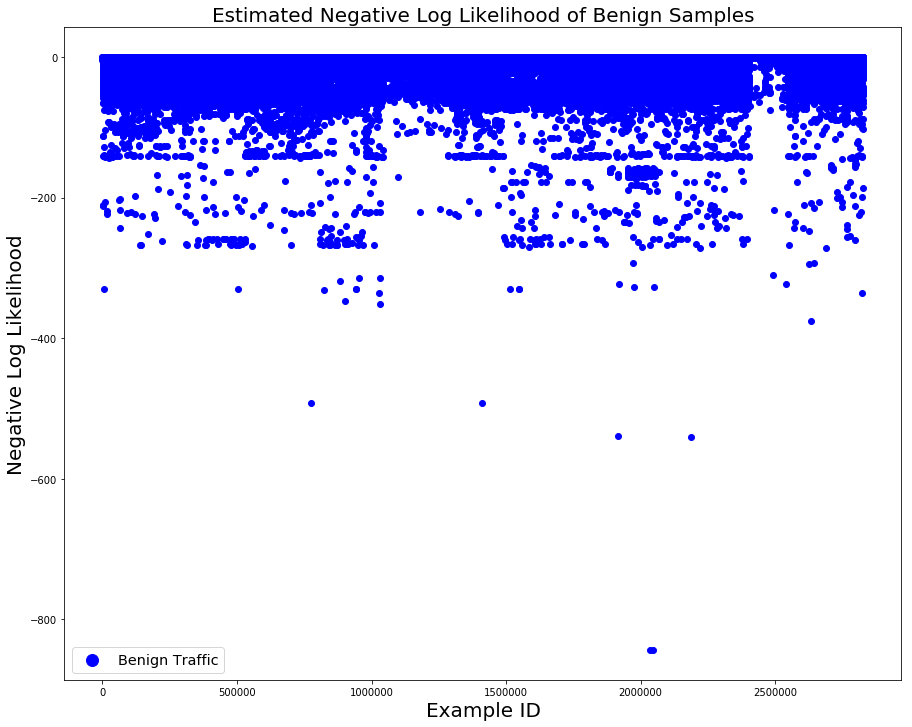

In [318]:
fig = plt.figure(figsize=(15,12))

plt.scatter(bal_ben.index, rbm_ben.score_samples(bal_ben), color='b', s=2)

legend = ['Benign Traffic']

ax.yaxis.label.set_size(40)
ax.xaxis.label.set_size(40)
ax.tick_params(labelsize=100)


plt.xlabel('Example ID', fontsize=(20))
plt.ylabel('Negative Log Likelihood', fontsize=(20))
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('Estimated Negative Log Likelihood of Benign Samples', size=20)
plt.legend(legend, loc='lower left', markerscale=2.0, fontsize='x-large')


plt.savefig('Free_energy_binary_benign.png');

In [470]:
benign_scores = rbm_ben.score_samples(df_benign.drop('Label', axis=1, inplace=False))

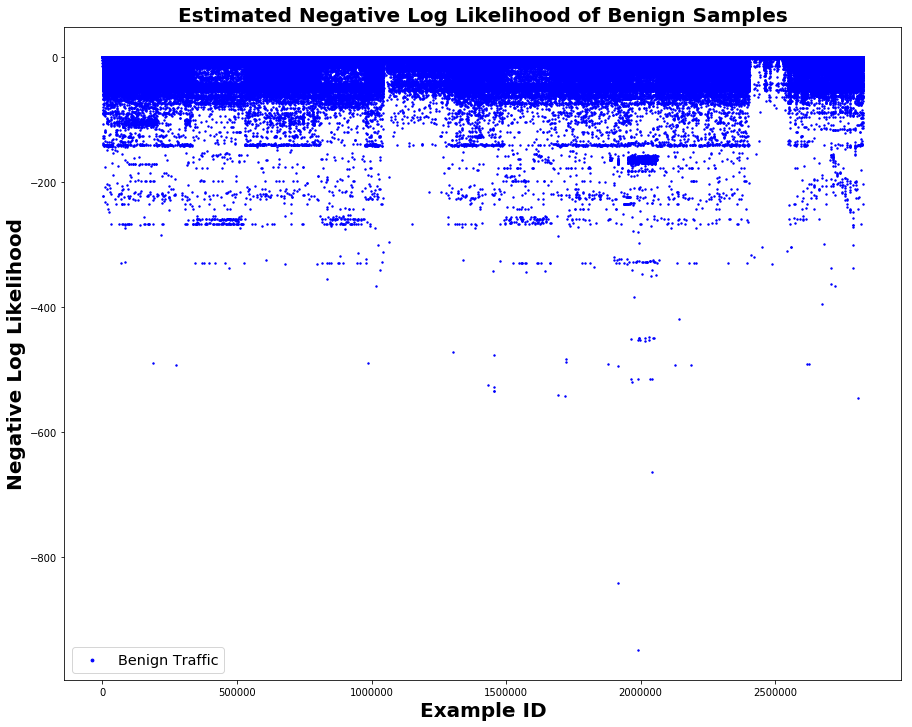

In [472]:
fig = plt.figure(figsize=(15,12))

plt.scatter(df_benign.index, benign_scores, color='b', s=2)

legend = ['Benign Traffic']

ax.yaxis.label.set_size(40)
ax.xaxis.label.set_size(40)
ax.tick_params(labelsize=100)


plt.xlabel('Example ID', fontsize=(20), weight='bold',)
plt.ylabel('Negative Log Likelihood', fontsize=(20), weight='bold',)
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('Estimated Negative Log Likelihood of Benign Samples', weight='bold', size=20)
plt.legend(legend, loc='lower left', markerscale=2.0, fontsize='x-large')


plt.savefig('Free_energy_benign.png');

In [ ]:
fig = plt.figure(figsize=(15,12))

plt.scatter(bal_mal.index, rbm_ben.score_samples(bal_mal), color='r')

legend = ['Malicious Traffic']

ax.yaxis.label.set_size(40)
ax.xaxis.label.set_size(40)
ax.tick_params(labelsize=100)


plt.xlabel('Example ID', fontsize=(20))
plt.ylabel('Negative Log Likelihood', fontsize=(20))
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('Estimated Negative Log Likelihood of Malicious Samples', size=20)
plt.legend(legend, loc='lower left', markerscale=2.0, fontsize='x-large')


plt.savefig('Free_energy_binary_malicious.png');


ValueError: x and y must be the same size

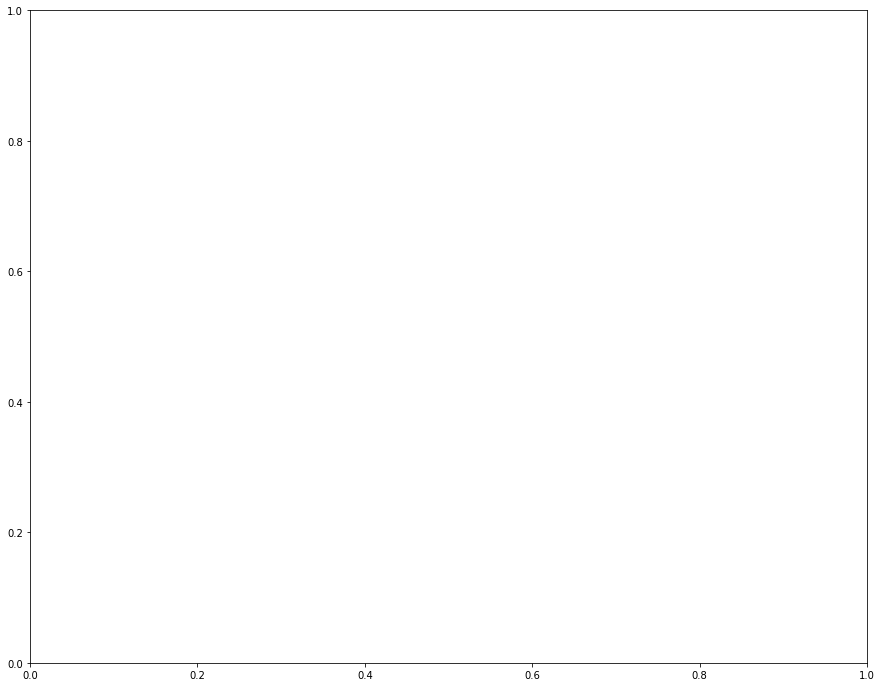

In [518]:
fig = plt.figure(figsize=(15,12))

plt.scatter(bal_ben.index, rbm_ben.score_samples(bal_ben), color='b', s=2)
plt.scatter(bal_mal.index, rbm_ben.score_samples(bal_mal), color='r', s=2)

legend = ['Benign Traffic', 'Malicious Traffic']

ax.yaxis.label.set_size(40)
ax.xaxis.label.set_size(40)
ax.tick_params(labelsize=100)


plt.xlabel('Example ID', weight='bold', fontsize=(20))
plt.ylabel('Negative Log Likelihood', weight='bold', fontsize=(20))
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('Estimated Negative Log Likelihood of Network Traffic', weight='bold', size=20)
plt.legend(legend, loc='lower left', markerscale=2.0, fontsize='x-large')


# plt.savefig('Free_energy_binary_both.png');

**Balanced Binary Classification with RBM Features:**

In [49]:
log6 = linear_model.LogisticRegression(verbose=1)
log6.solver = 'saga'
log6.max_iter = 100
log6.multi_class = 'auto'
log6.C = 100

%time log6.fit(rbm_ben.transform(X_bal_bin_train), Y_bal_bin_train)

%time rbm_predict2 = log6.predict(rbm_ben.transform(X_bal_bin_test))

print("Binary Logistic Classification using RBM features trained on benign data:\n%s\n" % (
    metrics.classification_report(Y_bal_bin_test, rbm_predict2)))


allDone()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 108 seconds
Wall time: 1min 49s


C:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished


Wall time: 426 ms
Binary Logistic Classification using RBM features trained on benign data:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87    111311
           1       0.84      0.94      0.89    111312

   micro avg       0.88      0.88      0.88    222623
   macro avg       0.89      0.88      0.88    222623
weighted avg       0.89      0.88      0.88    222623




In [50]:
basebalpred = log2.predict(X_bal_bin_test)
basebalpred0 = log2.predict(X_bal_bin_test[Y_bal_bin_test == 0])
basebalpred1 = log2.predict(X_bal_bin_test[Y_bal_bin_test == 1])

print(metrics.accuracy_score(Y_bal_bin_test, basebalpred))
print(metrics.accuracy_score(Y_bal_bin_test[Y_bal_bin_test == 0], basebalpred0))
print(metrics.accuracy_score(Y_bal_bin_test[Y_bal_bin_test == 1], basebalpred1))

print('-------------')

rbmbalpred = log6.predict(rbm_ben.transform(X_bal_bin_test))
rbmbalpred0 = log6.predict(rbm_ben.transform(X_bal_bin_test[Y_bal_bin_test == 0]))
rbmbalpred1 = log6.predict(rbm_ben.transform(X_bal_bin_test[Y_bal_bin_test == 1]))


print(metrics.accuracy_score(Y_bal_bin_test, rbmbalpred))
print(metrics.accuracy_score(Y_bal_bin_test[Y_bal_bin_test == 0], rbmbalpred0))
print(metrics.accuracy_score(Y_bal_bin_test[Y_bal_bin_test == 1], rbmbalpred1))

0.9278915475939143
0.9014472963139313
0.9543355613051603
-------------
0.8800213814385756
0.8200806748659162
0.9399615495184706


Average precision-recall score: 0.82


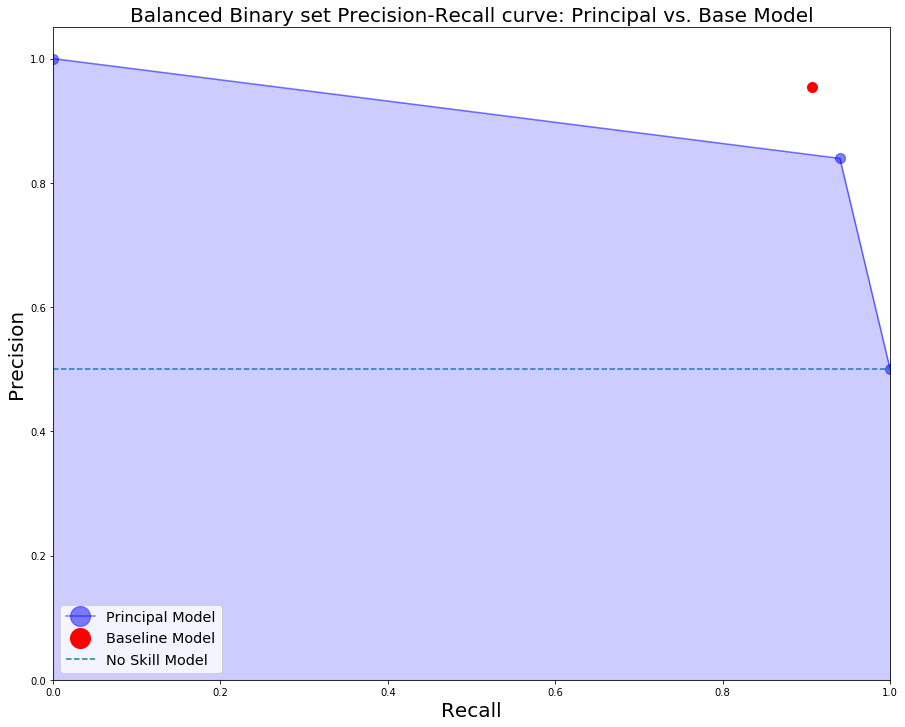

In [463]:
from inspect import signature
from sklearn.metrics import average_precision_score
from matplotlib.lines import Line2D


average_precision_rbm = average_precision_score(Y_bal_bin_test, rbm_predict2)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_rbm))

fig = plt.figure(figsize=(15,12))

# Get the precision and recall rates for both models
precision_rbm, recall_rbm, _ = precision_recall_curve(Y_bal_bin_test, rbm_predict2)
precision_base, recall_base, _ = precision_recall_curve(Y_bal_bin_test, log2_predict_1)




# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})


plt.plot(recall_rbm, precision_rbm, color='b', alpha=0.5, marker='.', markersize=20)
# plt.plot(recall_base, precision_base, color='r', alpha=0.5, marker='.')

prec_rbm = metrics.precision_score(Y_bal_bin_test, rbm_predict2)
rec_rbm = metrics.recall_score(Y_bal_bin_test, rbm_predict2)
# rbm_score = [prec_rbm, rec_rbm]

prec_base = metrics.precision_score(Y_bal_bin_test, log2_predict_1)
rec_base = metrics.recall_score(Y_bal_bin_test, log2_predict_1)
# base_score = [prec_base, rec_base]

# plt.plot(prec_rbm, rec_rbm, 'bo')
plt.plot(prec_base, rec_base, 'ro', markersize=10)


plt.fill_between(recall_rbm, precision_rbm, alpha=0.2, color='b', 
#                  **step_kwargs
                )
# plt.fill_between(recall_base, precision_base, alpha=0.2, color='r', 
# #                  **step_kwargs
#                 )

# axes= fig.add_axes([0.1,0.1,0.8,0.8])
markersize=5
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', linestyle='--')]
ax.legend(custom_lines, ['Principal Model', 'Baseline Model'])
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')

legend = ['Principal Model', 'Baseline Model', 'No Skill Model']


plt.xlabel('Recall', fontsize=(20))
plt.ylabel('Precision', fontsize=(20))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Balanced Binary set Precision-Recall curve: Principal vs. Base Model'.format(
          average_precision_rbm), size=(20))
plt.legend(legend, loc='lower left', markerscale=2.0, fontsize='x-large')


plt.savefig('PR_Curve_BalBin.png');

Average precision-recall score: 0.76


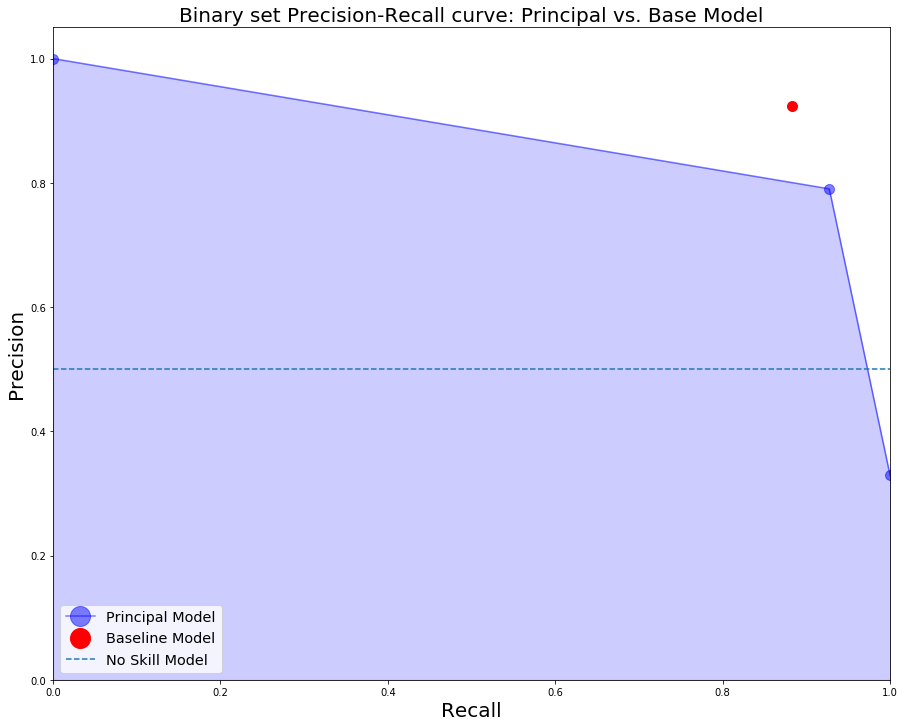

In [466]:
from inspect import signature
from sklearn.metrics import average_precision_score
from matplotlib.lines import Line2D


average_precision_rbm = average_precision_score(df_bin_test_labels, rbm_predict1)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_rbm))

fig = plt.figure(figsize=(15,12))

# Get the precision and recall rates for both models
precision_rbm, recall_rbm, _ = precision_recall_curve(df_bin_test_labels, rbm_predict1)
precision_base, recall_base, _ = precision_recall_curve(df_bin_test_labels, log_predict_1)




# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})


plt.plot(recall_rbm, precision_rbm, color='b', alpha=0.5, marker='.', markersize=20)
# plt.plot(recall_base, precision_base, color='r', alpha=0.5, marker='.')

prec_rbm = metrics.precision_score(df_bin_test_labels, rbm_predict1)
rec_rbm = metrics.recall_score(df_bin_test_labels, rbm_predict1)
# rbm_score = [prec_rbm, rec_rbm]

prec_base = metrics.precision_score(df_bin_test_labels, log_predict_1)
rec_base = metrics.recall_score(df_bin_test_labels, log_predict_1)
# base_score = [prec_base, rec_base]

# plt.plot(prec_rbm, rec_rbm, 'bo')
plt.plot(prec_base, rec_base, 'ro', markersize=10)


plt.fill_between(recall_rbm, precision_rbm, alpha=0.2, color='b', 
#                  **step_kwargs
                )
# plt.fill_between(recall_base, precision_base, alpha=0.2, color='r', 
# #                  **step_kwargs
#                 )

# axes= fig.add_axes([0.1,0.1,0.8,0.8])
markersize=5
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', linestyle='--')]
ax.legend(custom_lines, ['Principal Model', 'Baseline Model'])
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')


legend = ['Principal Model', 'Baseline Model', 'No Skill Model']


plt.xlabel('Recall', fontsize=(20))
plt.ylabel('Precision', fontsize=(20))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary set Precision-Recall curve: Principal vs. Base Model'.format(
          average_precision_rbm), size=(20))
plt.legend(legend, loc='lower left', markerscale=2.0, fontsize='x-large')


plt.savefig('PR_Curve_BalBin.png');

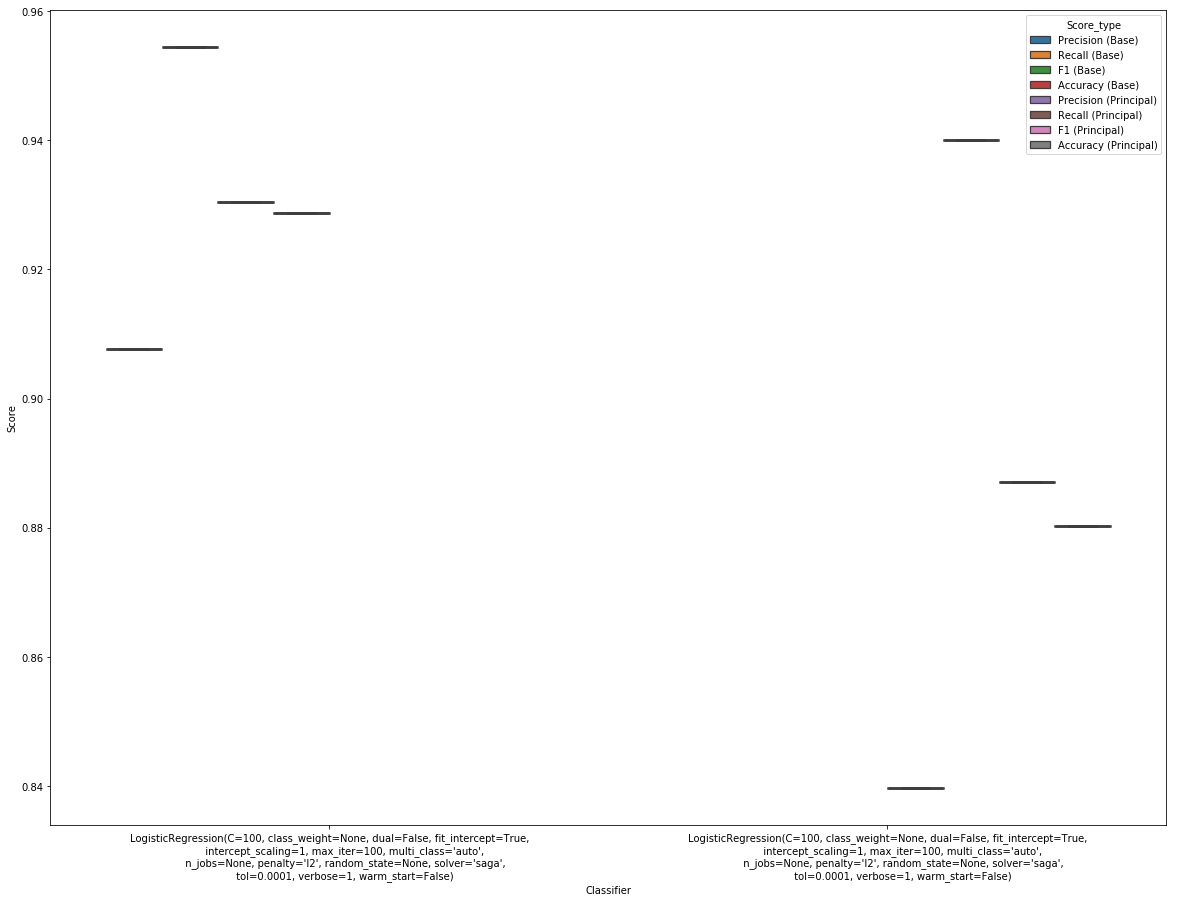

In [391]:
# # classifier_ls = ['Logistic_Regression', 'Random_Forest', 'Gradient_Boosting', 'K_NN']
# # classifier_dc = {
# #                'Logistic_Regression': LogisticRegression(class_weight='auto'),
# #                'Random_Forest': RandomForestClassifier(n_estimators=50, class_weight='auto'),
# #                'Gradient_Boosting': GradientBoostingClassifier(max_depth=5),
# #                'K_NN': KNeighborsClassifier(n_neighbors=5, weights='distance'),
# #                }
# # n_trials = 25
# # test_size_rt = 0.2


# #---------------------------

# #---------------------------
# # Calculating model performances for different models and several cv sets
# #---------------------------
# score_ls = []
# # for ic, (cl_name, Classifier) in enumerate(classifier_dc.items()):
# #     for trial in range(n_trials):
# # #         train_signals, test_signals, train_labels, test_labels = train_test_split(resampled_signals_df, resampled_response_sr, test_size=test_size_rt)
# # #         Classifier.fit(train_signals, train_labels)
        
# #         pred_labels = Classifier.predict(test_signals)
# #         precision = precision_score(test_labels, pred_labels, average='binary')
# #         score_ls.append([cl_name, precision, 'Precision'])
# #         recall = recall_score(test_labels, pred_labels, average='binary')
# #         score_ls.append([cl_name, recall,'Recall'])
# #         F1 = f1_score(test_labels, pred_labels, average='binary')
# #         score_ls.append([cl_name, F1,'f1 Score'])
# #         if (trial+1)%5==0:
# #             print (trial+1)*4, '%'
# #             sys.stdout.flush()
# #         #end
# #     #end
# # #end




# pred_labels_base = log2.predict(X_bal_bin_test)
# pred_labels_rbm = log6.predict(rbm_ben.transform(X_bal_bin_test))

# precision_base = []
# precision_base = metrics.precision_score(Y_bal_bin_test, pred_labels_base, average='binary')
# precision_rbm = metrics.precision_score(Y_bal_bin_test, pred_labels_rbm, average='binary')

# recall_base = metrics.recall_score(Y_bal_bin_test, pred_labels_base, average='binary')
# recall_rbm = metrics.recall_score(Y_bal_bin_test, pred_labels_rbm, average='binary')

# F1_base = metrics.f1_score(Y_bal_bin_test, pred_labels_base, average='binary')
# F1_rbm = metrics.f1_score(Y_bal_bin_test, pred_labels_rbm, average='binary')

# acc_base = metrics.accuracy_score(Y_bal_bin_test, pred_labels_base)
# acc_rbm = metrics.accuracy_score(Y_bal_bin_test, pred_labels_rbm)





# score_ls.append([log2, precision_base, 'Precision (Base)'])
# score_ls.append([log2, recall_base, 'Recall (Base)'])
# score_ls.append([log2, F1_base, 'F1 (Base)'])
# score_ls.append([log2, acc_base, 'Accuracy (Base)'])

# score_ls.append([log6, precision_rbm, 'Precision (Principal)'])
# score_ls.append([log6, recall_rbm, 'Recall (Principal)'])
# score_ls.append([log6, F1_rbm, 'F1 (Principal)'])
# score_ls.append([log6, acc_rbm, 'Accuracy (Principal)'])


# #---------------------------
# # Plotting boxplots of model performances
# #---------------------------

# plt.figure(figsize=(20,15))
# metrics_df = pd.DataFrame(score_ls, columns=['Classifier','Score','Score_type']) #building a dataframe with various metrics
# ax = sns.boxplot(x="Classifier", y="Score", hue="Score_type", data=metrics_df, linewidth=2.5) #producing the boxplot
# # metrics_df.to_pickle(onput_path + 'metrics_df.pkl') #saving results


In [390]:
metrics_df

,Classifier,Score,Score_type
0,"LogisticRegression(C=100, class_weight=None, d...",[0.0],Precision (Base)
1,"LogisticRegression(C=100, class_weight=None, d...",0.954389,Recall (Base)
2,"LogisticRegression(C=100, class_weight=None, d...",0.930478,F1 (Base)
3,"LogisticRegression(C=100, class_weight=None, d...",0.928691,Accuracy (Base)
4,"LogisticRegression(C=100, class_weight=None, d...",0.839682,Precision (Principal)
5,"LogisticRegression(C=100, class_weight=None, d...",0.940033,Recall (Principal)
6,"LogisticRegression(C=100, class_weight=None, d...",0.887029,F1 (Principal)
7,"LogisticRegression(C=100, class_weight=None, d...",0.880277,Accuracy (Principal)


In [323]:
# from inspect import signature
# from sklearn.metrics import average_precision_score


# fig = plt.figure(figsize=(10,7))
# plt.legend(loc='lower left')



# # For each class
# precision = dict()
# recall = dict()
# average_precision = dict()


# for i in range(n_classes):
#     precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
#                                                         y_score[:, i])
#     average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# # A "micro-average": quantifying score on all classes jointly
# precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
#     y_score.ravel())
# average_precision["micro"] = average_precision_score(Y_test, y_score,
#                                                      average="micro")
# print('Average precision score, micro-averaged over all classes: {0:0.2f}'
#       .format(average_precision["micro"]))


# plt.figure()
# plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
#                  **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title(
#     'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
#     .format(average_precision["micro"]))

**Meta-Class Classification with RBM Features:**

In [51]:
log7 = linear_model.LogisticRegression(verbose=1)
log7.solver = 'saga'
log7.max_iter = 100
log7.multi_class = 'auto'
log7.C = 100

%time log7.fit(rbm_ben.transform(df_meta_train), df_meta_train_labels)

%time rbm_predict3 = log7.predict(rbm_ben.transform(df_meta_test))

print("Meta-Class Logistic Classification using RBM features trained on benign data:\n%s\n" % (
    metrics.classification_report(df_meta_test_labels, rbm_predict3)))


allDone()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 388 seconds
Wall time: 6min 30s


C:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min finished


Wall time: 661 ms
Meta-Class Logistic Classification using RBM features trained on benign data:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94    227133
           1       0.98      0.32      0.48      2766
           2       0.87      0.94      0.90     75948
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00       436
           5       0.00      0.00      0.00       391
           6       0.80      0.99      0.89     31761

   micro avg       0.93      0.93      0.93    338444
   macro avg       0.52      0.45      0.46    338444
weighted avg       0.93      0.93      0.92    338444




C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
basemetapred = log3.predict(df_meta_test)
basemetapred0 = log3.predict(df_meta_test[df_meta_test_labels == 0])
basemetapred1 = log3.predict(df_meta_test[df_meta_test_labels == 1])
basemetapred2 = log3.predict(df_meta_test[df_meta_test_labels == 2])
basemetapred3 = log3.predict(df_meta_test[df_meta_test_labels == 3])
basemetapred4 = log3.predict(df_meta_test[df_meta_test_labels == 4])
basemetapred5 = log3.predict(df_meta_test[df_meta_test_labels == 5])
basemetapred6 = log3.predict(df_meta_test[df_meta_test_labels == 6])


print("Overall:", metrics.accuracy_score(df_meta_test_labels, basemetapred))
print("0:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 0], basemetapred0))
print("1:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 1], basemetapred1))
print("2:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 2], basemetapred2))
print("3:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 3], basemetapred3))
print("4:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 4], basemetapred4))
print("5:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 5], basemetapred5))
print("6:",metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 6], basemetapred6))


print('-------------')

rbmmetapred = log7.predict(rbm_ben.transform(df_meta_test))
rbmmetapred0 = log7.predict(rbm_ben.transform(df_meta_test[df_meta_test_labels == 0]))
rbmmetapred1 = log7.predict(rbm_ben.transform(df_meta_test[df_meta_test_labels == 1]))
rbmmetapred2 = log7.predict(rbm_ben.transform(df_meta_test[df_meta_test_labels == 2]))
rbmmetapred3 = log7.predict(rbm_ben.transform(df_meta_test[df_meta_test_labels == 3]))
rbmmetapred4 = log7.predict(rbm_ben.transform(df_meta_test[df_meta_test_labels == 4]))
rbmmetapred5 = log7.predict(rbm_ben.transform(df_meta_test[df_meta_test_labels == 5]))
rbmmetapred6 = log7.predict(rbm_ben.transform(df_meta_test[df_meta_test_labels == 6]))




print("Overall:", metrics.accuracy_score(df_meta_test_labels, rbmmetapred))
print("0:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 0], rbmmetapred0))
print("1:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 1], rbmmetapred1))
print("2:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 2], rbmmetapred2))
print("3:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 3], rbmmetapred3))
print("4:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 4], rbmmetapred4))
print("5:", metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 5], rbmmetapred5))
print("6:",metrics.accuracy_score(df_meta_test_labels[df_meta_test_labels == 6], rbmmetapred6))

Overall: 0.9666355438418173
0: 0.9613442344353308
1: 0.7830802603036876
2: 0.9878206141043873
3: 0.3333333333333333
4: 0.0
5: 0.020460358056265986
6: 0.9948994049305753
-------------
Overall: 0.9254913663708029
0: 0.9216626381899592
1: 0.3156182212581345
2: 0.9425659661873914
3: 0.0
4: 0.0
5: 0.0
6: 0.9895154434684047


**Multi-Class Classification with RBM Features:**

In [53]:
log8 = linear_model.LogisticRegression(verbose=1)
log8.solver = 'saga'
log8.max_iter = 100
log8.multi_class = 'auto'
log8.C = 100

%time log8.fit(rbm_ben.transform(df_full_train), df_full_train_labels)

%time rbm_predict4 = log8.predict(rbm_ben.transform(df_full_test))

print("Meta-Class Logistic Classification using RBM features trained on benign data:\n%s\n" % (
    metrics.classification_report(df_full_test_labels, rbm_predict4)))


allDone()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 690 seconds
Wall time: 11min 32s


C:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.5min finished


Wall time: 701 ms
Meta-Class Logistic Classification using RBM features trained on benign data:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95    227133
           1       0.00      0.00      0.00      1180
           2       0.92      0.18      0.30      1587
           3       0.91      0.51      0.65      1159
           4       0.72      0.18      0.29      1100
           5       0.91      0.80      0.85     46025
           6       0.79      0.65      0.71      2059
           7       0.84      0.85      0.84     25605
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00       301
          11       0.00      0.00      0.00       130
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00       391
          14       0.80      0.99      0.89     31761

   micro avg       0.91      0.91     

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
basefullpred = log4.predict(df_full_test)
basefullpred0 = log4.predict(df_full_test[df_full_test_labels == 0])
basefullpred1 = log4.predict(df_full_test[df_full_test_labels == 1])
basefullpred2 = log4.predict(df_full_test[df_full_test_labels == 2])
basefullpred3 = log4.predict(df_full_test[df_full_test_labels == 3])
basefullpred4 = log4.predict(df_full_test[df_full_test_labels == 4])
basefullpred5 = log4.predict(df_full_test[df_full_test_labels == 5])
basefullpred6 = log4.predict(df_full_test[df_full_test_labels == 6])
basefullpred7 = log4.predict(df_full_test[df_full_test_labels == 7])
basefullpred8 = log4.predict(df_full_test[df_full_test_labels == 8])
basefullpred9 = log4.predict(df_full_test[df_full_test_labels == 9])
basefullpred10 = log4.predict(df_full_test[df_full_test_labels == 10])
basefullpred11 = log4.predict(df_full_test[df_full_test_labels == 11])
basefullpred12 = log4.predict(df_full_test[df_full_test_labels == 12])
basefullpred13 = log4.predict(df_full_test[df_full_test_labels == 13])
basefullpred14 = log4.predict(df_full_test[df_full_test_labels == 14])



print("Total", metrics.accuracy_score(df_full_test_labels, basefullpred))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 0], basefullpred0))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 1], basefullpred1))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 2], basefullpred2))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 3], basefullpred3))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 4], basefullpred4))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 5], basefullpred5))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 6], basefullpred6))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 7], basefullpred7))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 8], basefullpred8))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 9], basefullpred9))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 10], basefullpred10))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 11], basefullpred11))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 12], basefullpred12))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 13], basefullpred13))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 14], basefullpred14))


print('-------------')

rbmfullpred = log8.predict(rbm_ben.transform(df_full_test))
rbmfullpred0 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 0]))
rbmfullpred1 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 1]))
rbmfullpred2 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 2]))
rbmfullpred3 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 3]))
rbmfullpred4 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 4]))
rbmfullpred5 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 5]))
rbmfullpred6 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 6]))
rbmfullpred7 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 7]))
rbmfullpred8 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 8]))
rbmfullpred9 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 9]))
rbmfullpred10 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 10]))
rbmfullpred11 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 11]))
rbmfullpred12 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 12]))
rbmfullpred13 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 13]))
rbmfullpred14 = log8.predict(rbm_ben.transform(df_full_test[df_full_test_labels == 14]))




print("Total:", metrics.accuracy_score(df_full_test_labels, rbmfullpred))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 0], rbmfullpred0))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 1], rbmfullpred1))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 2], rbmfullpred2))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 3], rbmfullpred3))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 4], rbmfullpred4))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 5], rbmfullpred5))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 6], rbmfullpred6))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 7], rbmfullpred7))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 8], rbmfullpred8))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 9], rbmfullpred9))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 10], rbmfullpred10))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 11], rbmfullpred11))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 12], rbmfullpred12))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 13], rbmfullpred13))
print(metrics.accuracy_score(df_full_test_labels[df_full_test_labels == 14], rbmfullpred14))

Total 0.972491756391013
0.9714440437981271
0.4788135593220339
0.996219281663516
0.542709232096635
0.8863636363636364
0.9947854426941879
0.8727537639630889
0.9965631712556141
1.0
0.0
0.0
0.0
0.0
0.023017902813299233
0.9957809892635622
-------------
Total: 0.9132323220385057
0.9542074467382546
0.0
0.18210459987397606
0.5116479723899914
0.18454545454545454
0.8009560021727322
0.647887323943662
0.8460066393282561
0.0
0.0
0.0
0.0
0.0
0.0
0.9886653442901672


In [55]:
print("Meta-Class Logistic regression prediction on TEST DATA with RBM features (SAGA/Multinomial):\n%s\n" % (
    metrics.classification_report(df_full_test_labels, log4_predict_1)))

Meta-Class Logistic regression prediction on TEST DATA with RBM features (SAGA/Multinomial):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    227133
           1       0.95      0.48      0.64      1180
           2       0.89      1.00      0.94      1587
           3       0.89      0.54      0.67      1159
           4       0.89      0.89      0.89      1100
           5       0.97      0.99      0.98     46025
           6       0.95      0.87      0.91      2059
           7       0.98      1.00      0.99     25605
           8       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00       301
          11       0.00      0.00      0.00       130
          12       0.00      0.00      0.00         4
          13       0.56      0.02      0.04       391
          14       0.88      1.00      0.94     31761

   micro avg       0.97      0.97      0.

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Training on benign and malicious data

This method trains the RBM on both benign and malicious data. There are 4 approaches: 

1. Training on binary-encoded target labels (Benign/Malicious)
1. Training on balanced binary-encoded target labels (50% benign, 50% malicious)
1. Training on meta-class target labels (0-6)
1. Training on multi-class target labels (0-14)


# ** THIS HAS BEEN SCRAPPED, INCLUDED IN FURTHER RESEARCH **

In [161]:
# rbm_bin = BernoulliRBM(n_iter=15, n_components=77, batch_size=1000, random_state=42, learning_rate=0.05, verbose=True)

# %time rbm_bin_trained = rbm_bin.fit_transform(df_bin_train)

# allDone()

In [160]:
# log9 = linear_model.LogisticRegression(verbose=1)
# log9.solver = 'saga'
# log9.max_iter = 100
# log9.multi_class = 'auto'
# log9.C = 100

# %time log9.fit(rbm_bin.transform(df_bin_train), df_bin_train_labels)

# %time rbm_predict1 = log9.predict(rbm_bin.transform(df_bin_test))

# print("Binary Logistic Classification using RBM features trained on benign data:\n%s\n" % (
#     metrics.classification_report(df_bin_test_labels, rbm_predict1)))


# allDone()

In [159]:
# rbm_bal_bin = BernoulliRBM(n_iter=15, n_components=77, batch_size=1000, random_state=42, learning_rate=0.05, verbose=True)

# %time rbm_bal_bin_trained = rbm_bal_bin.fit_transform(X_bal_bin_train)

# allDone()

In [158]:
# log10 = linear_model.LogisticRegression(verbose=1)
# log10.solver = 'saga'
# log10.max_iter = 100
# log10.multi_class = 'auto'
# log10.C = 100

# %time log10.fit(rbm_ben.transform(X_bal_bin_train), Y_bal_bin_train)

# %time rbm_predict2 = log10.predict(rbm_ben.transform(X_bal_bin_test))

# print("Binary Logistic Classification using RBM features trained on benign data:\n%s\n" % (
#     metrics.classification_report(Y_bal_bin_test, rbm_predict2)))

# allDone()

In [ ]:
# rbm_meta = BernoulliRBM(n_iter=15, n_components=77, batch_size=1000, random_state=42, learning_rate=0.1, verbose=True)

# %time rbm_meta_trained = rbm_meta.fit_transform(df_meta_train)

# allDone()

In [ ]:
# rbm_full = BernoulliRBM(n_iter=15, n_components=77, batch_size=1000, random_state=42, learning_rate=0.1, verbose=True)

# %time rbm_full_trained = rbm_full.fit_transform(df_full_train)

# allDone()

---
# Deep RBM

Below is a deep RBM model with 3 RBMs each with 77 components (hidden nodes) and a logistic regressor as the final layer.

This was chosen as a method to compare to a single-layer RBM on each dataset.

In [271]:
# rbm_1 = BernoulliRBM(n_iter=15, n_components=77, batch_size=1000, random_state=42, learning_rate=0.1, verbose=True)
# rbm_2 = BernoulliRBM(n_iter=15, n_components=77, batch_size=1000, random_state=42, learning_rate=0.1, verbose=True)
# rbm_3 = BernoulliRBM(n_iter=15, n_components=77, batch_size=1000, random_state=42, learning_rate=0.1, verbose=True)
# log_deep = linear_model.LogisticRegression(verbose=True)


# rbm_1_ben_trained = rbm_1.fit_transform(df_benign_train.drop('Label', axis=1, inplace=False))
# rbm_2_ben_trained = rbm_2.fit_transform(rbm_1_ben_trained)
# rbm_3_ben_trained = rbm_3.fit_transform(rbm_2_ben_trained)

# allDone()

### Binary Classification

In [272]:
# log_deep.fit(rbm_3_ben_trained.transform(df_bin_train), df_bin_train_labels)


# %time log_deep_predict = log_deep.predict(rbm_3_ben_trained.transform(rbm_2_ben_trained.transform(rbm_1_ben_trained.transform(df_bin_test))))

# print("Binary Logistic Classification using deep RBM trained on benign data:\n%s\n" % (
#     metrics.classification_report(df_bin_test_labels, log_deep_predict)))



### Balanced Binary Classification

In [273]:
# log_deep2.fit(rbm_3_ben_trained.transform(X_bal_bin_train), Y_bal_bin_train)

# %time log_deep_predict_2 = log_deep2.predict(rbm_3_ben_trained.transform(X_bal_bin_test))

# print("Balanced Binary Logistic Classification using deep RBM trained on benign data:\n%s\n" % (
#     metrics.classification_report(Y_bal_bin_test, log_deep_predict_2)))



### Meta-Class Classification

In [ ]:
# log_deep3.fit(rbm_3_ben_trained.transform(df_meta_train), df_meta_train_labels) 

# %time log_deep_predict_3 = log_deep3.predict(rbm_3_ben_trained.transform(df_meta_test))

# print("Meta-class Logistic Classification using deep RBM trained on benign data:\n%s\n" % (
#     metrics.classification_report(df_meta_test_labels, log_deep_predict_3)))



### Multi-Class Classification

In [ ]:
# log_deep4.fit(rbm_3_ben_trained.transform(df_multi_train), df_multi_train_labels) 

# %time log_deep_predict_4 = log_deep4.predict(rbm_3_ben_trained.transform(df_multi_test))

# print("Multi-class Logistic Classification using deep RBM trained on benign data:\n%s\n" % (
#     metrics.classification_report(df_multi_test_labels, log_deep_predict_4)))



---
---
---

# Data Visualization


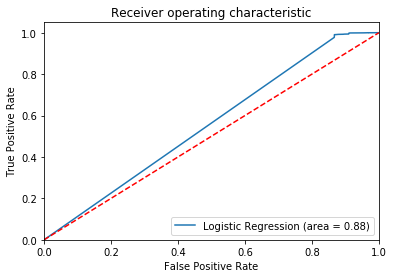

In [53]:
logit_roc_auc_2 = roc_auc_score(Y_bal_bin_test, rbm_predict2)
fpr, tpr, thresholds = roc_curve(Y_bal_bin_test, log6.predict_proba(X_bal_bin_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

Average precision-recall score: 0.76
Average precision-recall score: 0.93


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.93')

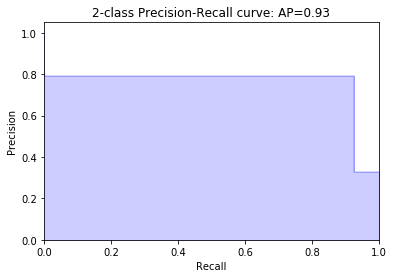

In [283]:
from inspect import signature
from sklearn.metrics import average_precision_score, recall_score

average_recall = recall_score(df_bin_test_labels, rbm_predict1)
average_precision = average_precision_score(df_bin_test_labels, rbm_predict1)


print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

print('Average precision-recall score: {0:0.2f}'.format(
      average_recall))

precision, recall, _ = precision_recall_curve(df_bin_test_labels, rbm_predict1)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

Average precision-recall score: 0.82


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.82 versus Logit')

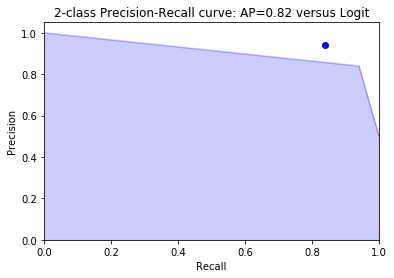

In [81]:
from inspect import signature
from sklearn.metrics import average_precision_score

average_precision = average_precision_score(Y_bal_bin_test, rbm_predict2)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(Y_bal_bin_test, rbm_predict2)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})
plt.plot(recall, precision, color='b', alpha=0.2,
#          where='post'
        )

prec = metrics.precision_score(Y_bal_bin_test, rbm_predict2)
rec = metrics.recall_score(Y_bal_bin_test, rbm_predict2)

plt.plot(prec, rec, 'bo')
plt.fill_between(recall, precision, alpha=0.2, color='b', 
#                  **step_kwargs
                )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f} versus Logit'.format(
          average_precision))


# plt.savefig('PR_Curve_BalBin.png');

C:\Anaconda\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


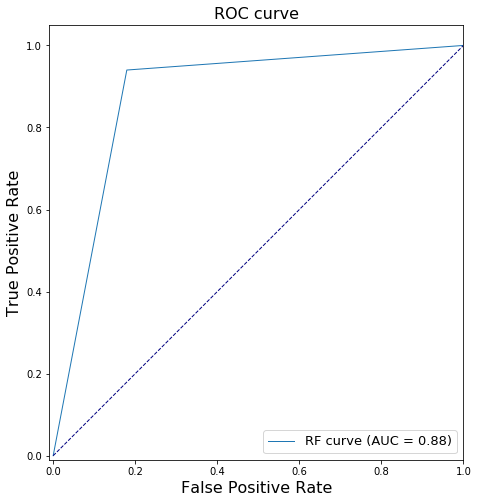

In [88]:
fpr_rf, tpr_rf, _ = roc_curve(Y_bal_bin_test, rbm_predict2)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,8))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.05])
plt.plot(fpr_rf, tpr_rf, lw=1, label='{} curve (AUC = {:0.2f})'.format('RF',roc_auc_rf))


plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [144]:
# fpr, tpr, thresholds = roc_curve(Y_bal_bin_test, rbm_predict2)


# # calculate precision-recall curve
# precision, recall, thresholds = precision_recall_curve(Y_bal_bin_test, rbm_predict2)
# # calculate F1 score
# f1 = f1_score(Y_bal_bin_test, rbm_predict2)
# # calculate precision-recall AUC
# auc = auc(recall, precision)
# # calculate average precision score
# ap = average_precision_score(testy, probs)
# print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# # plot no skill
# pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# # plot the precision-recall curve for the model
# pyplot.plot(recall, precision, marker='.')
# # show the plot
# pyplot.show()

In [ ]:
# classifier_ls = ['Logistic_Regression', 'Random_Forest', 'Gradient_Boosting', 'K_NN']
# classifier_dc = {
#                'Logistic_Regression': LogisticRegression(class_weight='auto'),
#                'Random_Forest': RandomForestClassifier(n_estimators=50, class_weight='auto'),
#                'Gradient_Boosting': GradientBoostingClassifier(max_depth=5),
#                'K_NN': KNeighborsClassifier(n_neighbors=5, weights='distance'),
#                }
# n_trials = 25
# test_size_rt = 0.2


#---------------------------

#---------------------------
# Calculating model performances for different models and several cv sets
#---------------------------
score_ls = []
# for ic, (cl_name, Classifier) in enumerate(classifier_dc.items()):
#     for trial in range(n_trials):
# #         train_signals, test_signals, train_labels, test_labels = train_test_split(resampled_signals_df, resampled_response_sr, test_size=test_size_rt)
# #         Classifier.fit(train_signals, train_labels)
        
#         pred_labels = Classifier.predict(test_signals)
#         precision = precision_score(test_labels, pred_labels, average='binary')
#         score_ls.append([cl_name, precision, 'Precision'])
#         recall = recall_score(test_labels, pred_labels, average='binary')
#         score_ls.append([cl_name, recall,'Recall'])
#         F1 = f1_score(test_labels, pred_labels, average='binary')
#         score_ls.append([cl_name, F1,'f1 Score'])
#         if (trial+1)%5==0:
#             print (trial+1)*4, '%'
#             sys.stdout.flush()
#         #end
#     #end
# #end




benign_prec = log2.predict(X_bal_bin_test)
pred_labels_rbm = log6.predict(rbm_ben.transform(X_bal_bin_test))

precision_base = []
precision_base = metrics.precision_score(Y_bal_bin_test, pred_labels_base, average='binary')
precision_rbm = metrics.precision_score(Y_bal_bin_test, pred_labels_rbm, average='binary')

recall_base = metrics.recall_score(Y_bal_bin_test, pred_labels_base, average='binary')
recall_rbm = metrics.recall_score(Y_bal_bin_test, pred_labels_rbm, average='binary')

F1_base = metrics.f1_score(Y_bal_bin_test, pred_labels_base, average='binary')
F1_rbm = metrics.f1_score(Y_bal_bin_test, pred_labels_rbm, average='binary')

acc_base = metrics.accuracy_score(Y_bal_bin_test, pred_labels_base)
acc_rbm = metrics.accuracy_score(Y_bal_bin_test, pred_labels_rbm)





score_ls.append([log2, precision_base, 'Precision (Base)'])
score_ls.append([log2, recall_base, 'Recall (Base)'])
score_ls.append([log2, F1_base, 'F1 (Base)'])
score_ls.append([log2, acc_base, 'Accuracy (Base)'])

score_ls.append([log6, precision_rbm, 'Precision (Principal)'])
score_ls.append([log6, recall_rbm, 'Recall (Principal)'])
score_ls.append([log6, F1_rbm, 'F1 (Principal)'])
score_ls.append([log6, acc_rbm, 'Accuracy (Principal)'])


#---------------------------
# Plotting boxplots of model performances
#---------------------------

plt.figure(figsize=(20,15))
metrics_df = pd.DataFrame(score_ls, columns=['Classifier','Score','Score_type']) #building a dataframe with various metrics
ax = sns.boxplot(x="Classifier", y="Score", hue="Score_type", data=metrics_df, linewidth=2.5) #producing the boxplot
# metrics_df.to_pickle(onput_path + 'metrics_df.pkl') #saving results


Separate the malicious data into individual categories with the bal_mal indexes for multi-color graphing:

In [90]:
# mal_scores = pd.DataFrame(columns = [df_malicious.Label.unique()])
# # mal_scores.append(scores, ignore_index=False)

In [488]:

mal_scores = df_full[df_full.Label != 0]

mal_scores.Label.unique()

df_mal_scores = pd.DataFrame(rbm_ben.score_samples(mal_scores.drop('Label', axis=1, inplace=False)))

df_mal_scores.columns = ['Score']

labels_x = mal_scores.Label.copy().reset_index()
labels_x.drop('index', axis=1, inplace=True)
df_mal_scores['Label'] = labels_x

df_mal_scores['Label'] = labels_x
df_mal_scores

,Score,Label
0,-0.392520,2
1,-13.864559,2
2,-0.029472,2
3,-0.004994,2
4,-0.172570,2
5,-0.115440,2
6,-0.115435,2
7,-0.895089,2
8,-0.006971,2
9,-0.560005,2


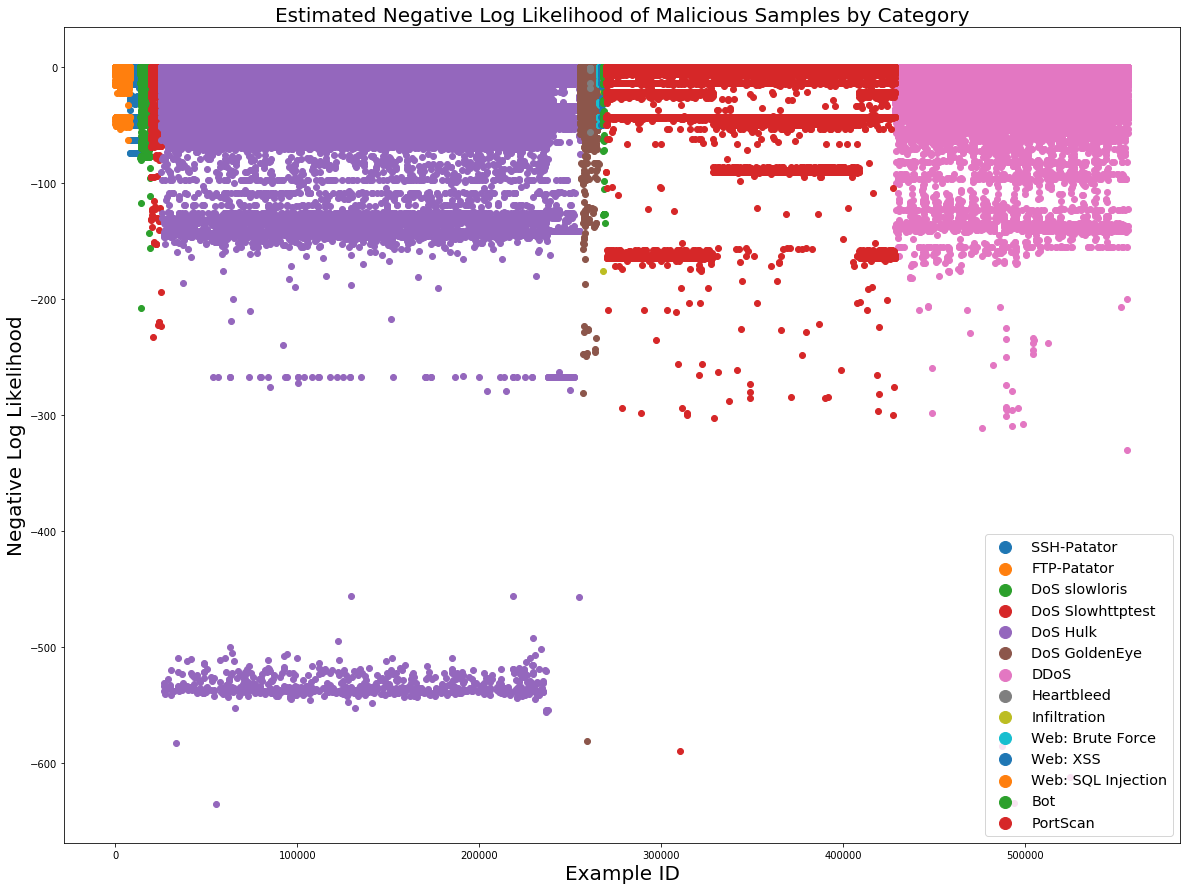

In [142]:
fig = plt.figure(figsize=(20,15))

# plt.scatter(bal_mal.index, rbm_ben.score_samples(bal_mal), color='r')

# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "PortScan"].drop('Label', axis=1, inplace=False)), color = 'yellow')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Bot"].drop('Label', axis=1, inplace=False)), color = 'magenta')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Infiltration"].drop('Label', axis=1, inplace=False)), color = 'darkorange')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Heartbleed"].drop('Label', axis=1, inplace=False)), color = 'coral')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "FTP-Patator"].drop('Label', axis=1, inplace=False)), color = 'maroon')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "SSH-Patator"].drop('Label', axis=1, inplace=False)), color = 'firebrick')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "DoS Hulk"].drop('Label', axis=1, inplace=False)), color = 'green')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "DoS slowloris"].drop('Label', axis=1, inplace=False)), color = 'aquamarine')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "DoS Slowhttptest"].drop('Label', axis=1, inplace=False)), color = 'lightgreen')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "DDoS"].drop('Label', axis=1, inplace=False)), color = 'lime')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "DoS GoldenEye"].drop('Label', axis=1, inplace=False)), color = 'forestgreen')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Web Attack � Brute Force"].drop('Label', axis=1, inplace=False)), color = 'dodgerblue')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Web Attack � XSS"].drop('Label', axis=1, inplace=False)), color = 'cyan')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Web Attack � Sql Injection"].drop('Label', axis=1, inplace=False)), color = 'turquoise')

plt.scatter(df_mal_scores.index[df_mal_scores.Label == 1], df_mal_scores.Score[df_mal_scores.Label == 1])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 2], df_mal_scores.Score[df_mal_scores.Label == 2])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 3], df_mal_scores.Score[df_mal_scores.Label == 3])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 4], df_mal_scores.Score[df_mal_scores.Label == 4])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 5], df_mal_scores.Score[df_mal_scores.Label == 5])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 6], df_mal_scores.Score[df_mal_scores.Label == 6])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 7], df_mal_scores.Score[df_mal_scores.Label == 7])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 8], df_mal_scores.Score[df_mal_scores.Label == 8])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 9], df_mal_scores.Score[df_mal_scores.Label == 9])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 10], df_mal_scores.Score[df_mal_scores.Label == 10])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 11], df_mal_scores.Score[df_mal_scores.Label == 11])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 12], df_mal_scores.Score[df_mal_scores.Label == 12])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 13], df_mal_scores.Score[df_mal_scores.Label == 13])
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 14], df_mal_scores.Score[df_mal_scores.Label == 14])






legend = [
            "SSH-Patator",
            "FTP-Patator",
            "DoS slowloris",
            "DoS Slowhttptest",
            "DoS Hulk",
            "DoS GoldenEye",
            "DDoS",
            "Heartbleed",
            'Infiltration',
            "Web: Brute Force",
            "Web: XSS",
            "Web: SQL Injection",
            'Bot',
            'PortScan',
              ]

ax.yaxis.label.set_size(40)
ax.xaxis.label.set_size(40)
ax.tick_params(labelsize=100)


plt.xlabel('Example ID', fontsize=(20))
plt.ylabel('Negative Log Likelihood', fontsize=(20))
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('Estimated Negative Log Likelihood of Malicious Samples by Category', size=20)
plt.legend(legend, loc='lower right', markerscale=2.0, fontsize='x-large')


# plt.savefig('Free_energy_all_categories.png');

allDone()

In [512]:
# df_meta_scores = pd.DataFrame()
# df_meta_scores['Score'] = rbm_ben.score_samples(df_meta_test)
# df_meta_scores['Label'] = df_meta_test_labels


# labels_x = df_meta_test_labels.copy().reset_index()
# labels_x.drop('index', axis=1, inplace=True)
# df_meta_scores['Label'] = labels_x
# df_meta_scores.head()



meta_mal_scores = df_meta[df_meta.Label != 0]

meta_mal_scores.Label.unique()

df_meta_scores = pd.DataFrame(rbm_ben.score_samples(meta_mal_scores.drop('Label', axis=1, inplace=False)))

df_meta_scores.columns = ['Score']

labels_x = meta_mal_scores.Label.copy().reset_index()
labels_x.drop('index', axis=1, inplace=True)
df_meta_scores['Label'] = labels_x

df_meta_scores['Label'] = labels_x
df_meta_scores = df_meta_scores.sort_values('Label')
df_meta_scores

,Score,Label
0,-0.392520,1
9214,-0.005621,1
9215,-0.015142,1
9216,-5.470645,1
9217,-0.029046,1
9218,-4.669177,1
9219,-5.465574,1
9220,-1.279820,1
9221,-0.005848,1
9222,-0.184635,1


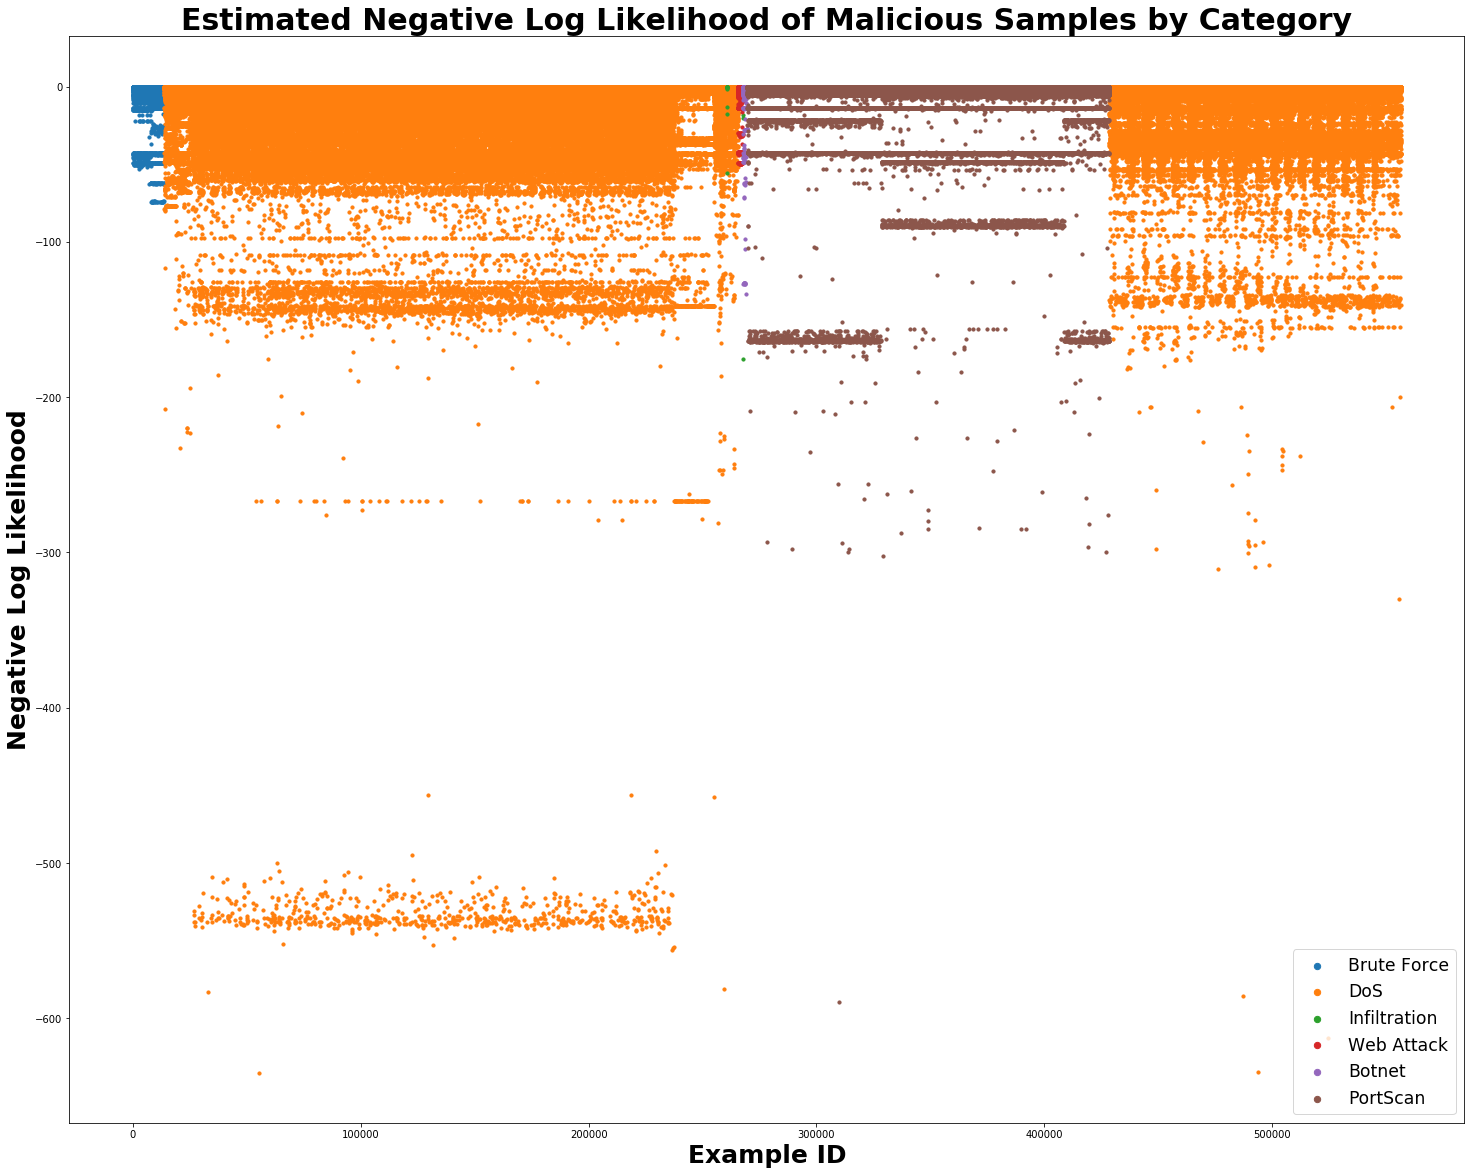

In [513]:
fig = plt.figure(figsize=(25,20))

plt.scatter(df_meta_scores.index[df_meta_scores.Label == 1], df_meta_scores.Score[df_meta_scores.Label == 1], s=10)
plt.scatter(df_meta_scores.index[df_meta_scores.Label == 2], df_meta_scores.Score[df_meta_scores.Label == 2], s=10)
plt.scatter(df_meta_scores.index[df_meta_scores.Label == 3], df_meta_scores.Score[df_meta_scores.Label == 3], s=10)
plt.scatter(df_meta_scores.index[df_meta_scores.Label == 4], df_meta_scores.Score[df_meta_scores.Label == 4], s=10)
plt.scatter(df_meta_scores.index[df_meta_scores.Label == 5], df_meta_scores.Score[df_meta_scores.Label == 5], s=10)
plt.scatter(df_meta_scores.index[df_meta_scores.Label == 6], df_meta_scores.Score[df_meta_scores.Label == 6], s=10)




legend = [
            'Brute Force',
            "DoS",
            "Infiltration",
            'Web Attack',
            'Botnet',
            'PortScan',
              ]



ax.yaxis.label.set_size(40)
ax.xaxis.label.set_size(40)
ax.tick_params(labelsize=100)


# ax.legend(prop={'size': 6})
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)


plt.xlabel('Example ID', fontsize=(25), weight='bold')
plt.ylabel('Negative Log Likelihood', fontsize=(25), weight='bold')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('Estimated Negative Log Likelihood of Malicious Samples by Category', size=30, weight='bold')
plt.legend(legend, loc='lower right', markerscale=2.0, fontsize='xx-large')


plt.savefig('legend_I_am_so_done_with_this_shit.png');

allDone()

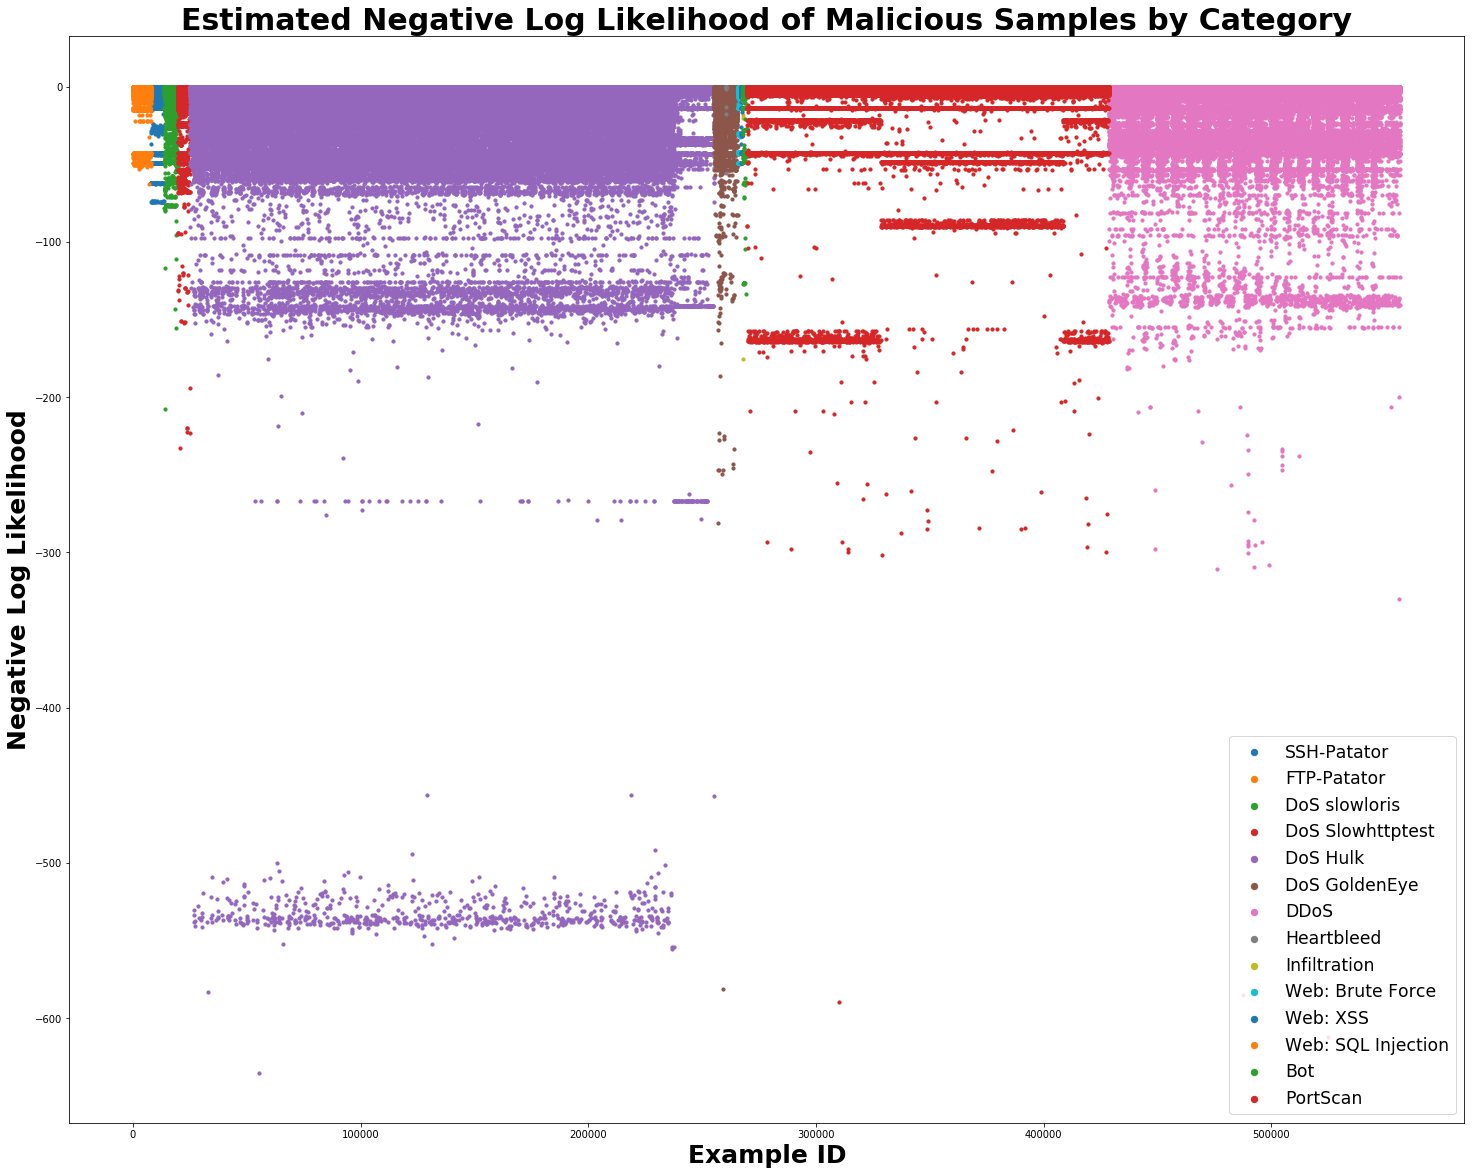

In [418]:
fig = plt.figure(figsize=(25,20))

# plt.scatter(bal_mal.index, rbm_ben.score_samples(bal_mal), color='r')

# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "PortScan"].drop('Label', axis=1, inplace=False)), color = 'yellow')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Bot"].drop('Label', axis=1, inplace=False)), color = 'magenta')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Infiltration"].drop('Label', axis=1, inplace=False)), color = 'darkorange')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Heartbleed"].drop('Label', axis=1, inplace=False)), color = 'coral')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "FTP-Patator"].drop('Label', axis=1, inplace=False)), color = 'maroon')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "SSH-Patator"].drop('Label', axis=1, inplace=False)), color = 'firebrick')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "DoS Hulk"].drop('Label', axis=1, inplace=False)), color = 'green')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "DoS slowloris"].drop('Label', axis=1, inplace=False)), color = 'aquamarine')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "DoS Slowhttptest"].drop('Label', axis=1, inplace=False)), color = 'lightgreen')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "DDoS"].drop('Label', axis=1, inplace=False)), color = 'lime')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "DoS GoldenEye"].drop('Label', axis=1, inplace=False)), color = 'forestgreen')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Web Attack � Brute Force"].drop('Label', axis=1, inplace=False)), color = 'dodgerblue')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Web Attack � XSS"].drop('Label', axis=1, inplace=False)), color = 'cyan')
# plt.scatter(df_malicious.index, rbm_ben.score_samples(df_malicious[df_malicious.Label == "Web Attack � Sql Injection"].drop('Label', axis=1, inplace=False)), color = 'turquoise')

plt.scatter(df_mal_scores.index[df_mal_scores.Label == 1], df_mal_scores.Score[df_mal_scores.Label == 1], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 2], df_mal_scores.Score[df_mal_scores.Label == 2], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 3], df_mal_scores.Score[df_mal_scores.Label == 3], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 4], df_mal_scores.Score[df_mal_scores.Label == 4], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 5], df_mal_scores.Score[df_mal_scores.Label == 5], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 6], df_mal_scores.Score[df_mal_scores.Label == 6], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 7], df_mal_scores.Score[df_mal_scores.Label == 7], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 8], df_mal_scores.Score[df_mal_scores.Label == 8], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 9], df_mal_scores.Score[df_mal_scores.Label == 9], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 10], df_mal_scores.Score[df_mal_scores.Label == 10], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 11], df_mal_scores.Score[df_mal_scores.Label == 11], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 12], df_mal_scores.Score[df_mal_scores.Label == 12], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 13], df_mal_scores.Score[df_mal_scores.Label == 13], s=10)
plt.scatter(df_mal_scores.index[df_mal_scores.Label == 14], df_mal_scores.Score[df_mal_scores.Label == 14], s=10)






# legend = [
#             "SSH-Patator (48%)[0%]",
#             "FTP-Patator (100%)[16%]",
#             "DoS slowloris (54%)[51%]",
#             "DoS Slowhttptest (89%)[19%]",
#             "DoS Hulk (99%)[80%]",
#             "DoS GoldenEye (87%)[65%]",
#             "DDoS (100%)[85%]",
#             "Heartbleed (100%)[0%]",
#             'Infiltration (0%)[0%]',
#             "Web: Brute Force (0%)[0%]",
#             "Web: XSS (0%)[0%]",
#             "Web: SQL Injection (0%)[0%]",
#             'Bot (3%)[0%]',
#             'PortScan (100%)[99%]',
#               ]


legend = [
            "SSH-Patator",
            "FTP-Patator",
            "DoS slowloris",
            "DoS Slowhttptest",
            "DoS Hulk",
            "DoS GoldenEye",
            "DDoS",
            "Heartbleed",
            'Infiltration',
            "Web: Brute Force",
            "Web: XSS",
            "Web: SQL Injection",
            'Bot',
            'PortScan',
              ]


ax.yaxis.label.set_size(40)
ax.xaxis.label.set_size(40)
ax.tick_params(labelsize=100)


# ax.legend(prop={'size': 6})
params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
plt.rcParams.update(params)


plt.xlabel('Example ID', fontsize=(25), weight='bold')
plt.ylabel('Negative Log Likelihood', fontsize=(25), weight='bold')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('Estimated Negative Log Likelihood of Malicious Samples by Category', size=30, weight='bold')
plt.legend(legend, loc='lower right', markerscale=2.0, fontsize='xx-large')


plt.savefig('legend_I_am_so_done_with_this_shit.png');

allDone()

In [256]:
from sklearn.preprocessing import StandardScaler


ben_scores = rbm_ben.score_samples(df_benign_train.drop('Label', axis=1, inplace=False))

scaler = StandardScaler()

ben_scores_scaled = scaler.fit_transform(ben_scores.reshape(-1,1))

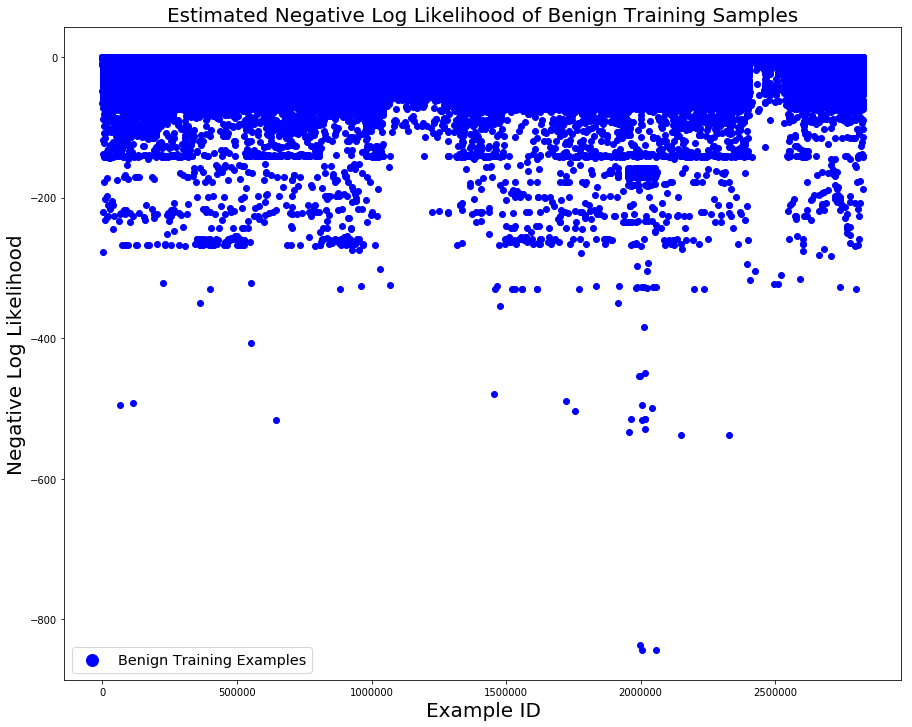

In [262]:
fig = plt.figure(figsize=(15,12))

plt.scatter(df_benign_train.index, ben_scores, color='b')

# mean = np.mean(ben_scores)
# plt.plot(mean, color='r')

legend = ['Benign Training Examples']

ax.yaxis.label.set_size(40)
ax.xaxis.label.set_size(40)
ax.tick_params(labelsize=100)


plt.xlabel('Example ID', fontsize=(20))
plt.ylabel('Negative Log Likelihood', fontsize=(20))
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
plt.title('Estimated Negative Log Likelihood of Benign Training Samples', size=20)
plt.legend(legend, loc='lower left', markerscale=2.0, fontsize='x-large')


plt.savefig('Free_energy_benign_training.png');

---

# Graphs

### Recall vs. Number of Examples to Learn From:

In [147]:
df_full.Label.value_counts()

0     1135660
5      230124
14     158804
7      128025
6       10293
2        7935
1        5897
3        5796
4        5499
13       1956
10       1507
11        652
9          36
12         21
8          11
Name: Label, dtype: int64

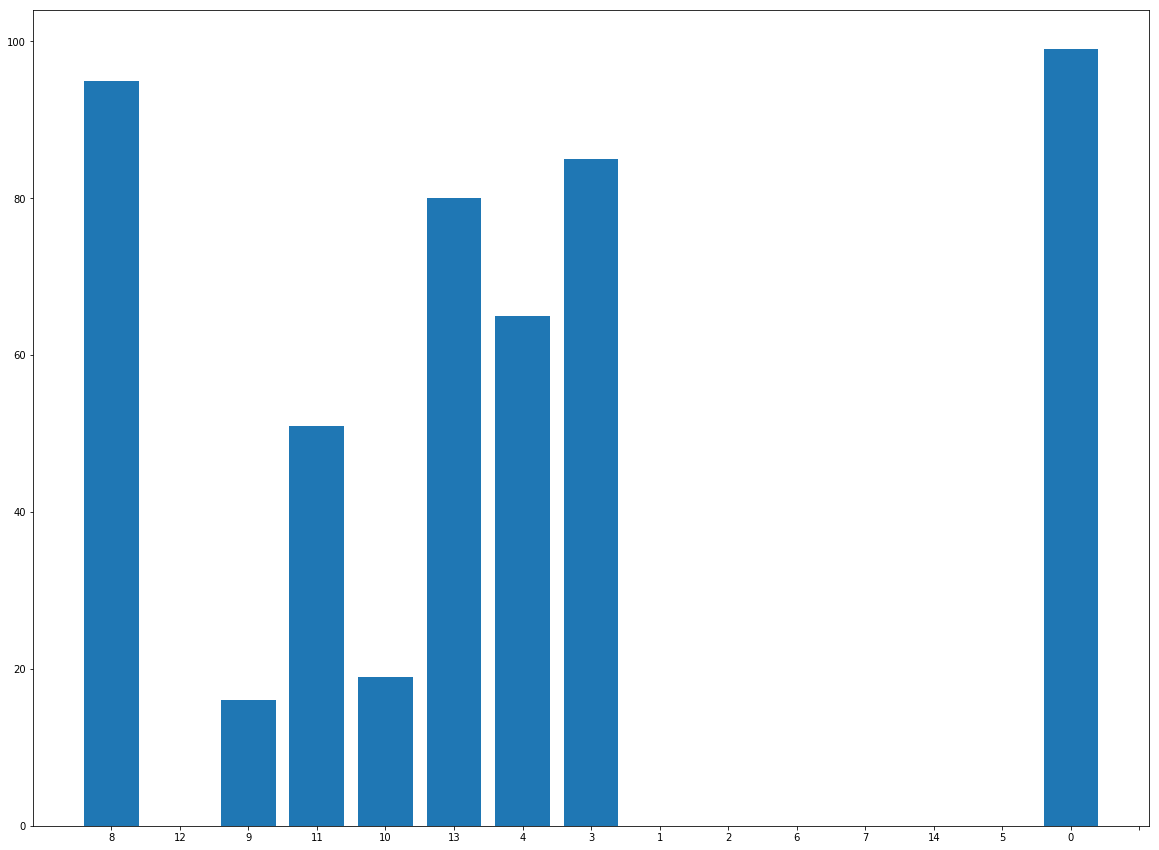

In [244]:
fig = plt.figure(figsize = (20,15))

# x = [8, 12, 9, 11, 10, 13, 4, 3, 1, 2, 6, 7, 14, 5, 0]
recall = [0, 0, 0, 0, 0, 0, 19, 51, 16, 0, 65, 85, 99, 80, 95]

x = [8, 12, 9, 11, 10, 13, 4, 3, 1, 2, 6, 7, 14, 5, 0]


# plt.xticks(x)
# data = [[8,0], [12,0], [9,0], [11,0], [13,19], [4,51], [3,0], [1,16], [2,65], [6,85], [7,99], [5,80], [0,95]]
plt.xticks(range(100), x)

ax = plt.bar(x, y)

In [250]:
df_full_train_labels.value_counts()

0     908527
5     184099
14    127043
7     102420
6       8234
2       6348
1       4717
3       4637
4       4399
13      1565
10      1206
11       522
9         29
12        17
8          9
Name: Label, dtype: int64

In [348]:
lab = ['Heartbleed (11)', 
       'SQL-Injection (21)', 
       'Infiltration (36)', 
       'Web-XSS (652)', 
       'Web: Brute Force (1507)', 
       'Botnet (1956)', 
       'DoS Slowhttptest (5499)',
       'DoS Slowloris (5796)', 
       'FTP-Patator (5897)', 
       'SSH-Patator (7935)', 
       'DoS GoldenEye (10293)',
       'DDoS (128025)', 
       'PortScan (158804)', 
       'DoS Hulk (230124)',
       'Benign (908527)']


df_plot = pd.DataFrame(columns = ['Recall', 'Label'])
df_plot.Recall = recall
df_plot.Label = lab

df_plot

,Recall,Label
0,0,Heartbleed (11)
1,0,SQL-Injection (21)
2,0,Infiltration (36)
3,0,Web-XSS (652)
4,0,Web: Brute Force (1507)
5,0,Botnet (1956)
6,19,DoS Slowhttptest (5499)
7,51,DoS Slowloris (5796)
8,16,FTP-Patator (5897)
9,0,SSH-Patator (7935)


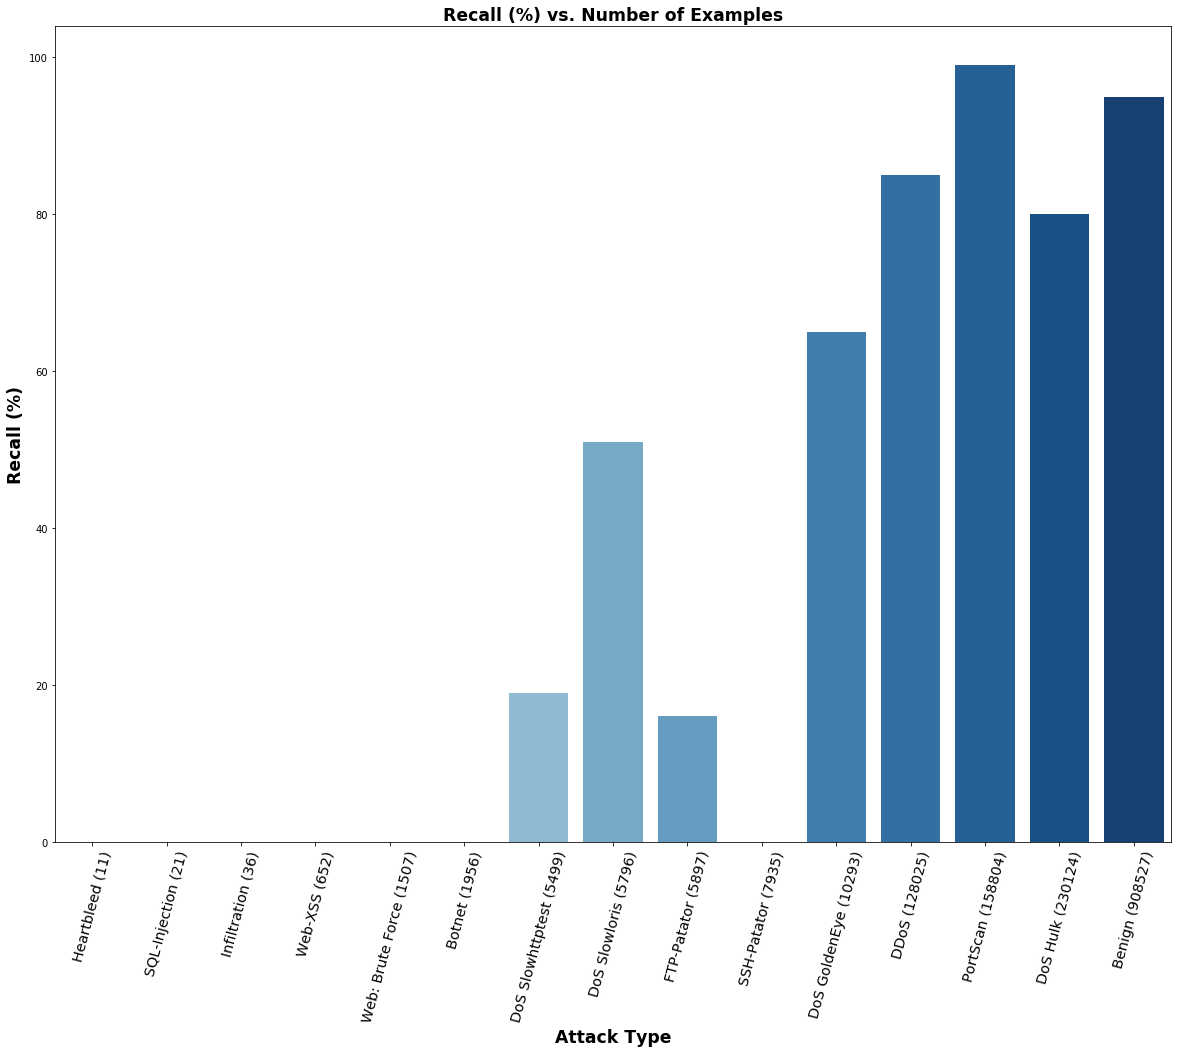

In [349]:
# sort, then reset index
# df_plot = df_plot.sort_values('Recall', ascending = True).reset_index(drop=True)
plt.figure(figsize = (20,15))


ax = sns.barplot(x=df_plot.index, y=df_plot.Recall, palette=("Blues"))
ax.set_xlabel("Attack Type", weight='bold', size='xx-large')
ax.set_ylabel("Recall (%)", weight='bold', size='xx-large')
ax.set_title('Recall (%) vs. Number of Examples', weight='bold', size='xx-large')



# Use name column to label x ticks
_ = ax.set_xticklabels(df_plot.Label, rotation=75, size='x-large')\


plt.savefig('Recall_vs_examples.png');

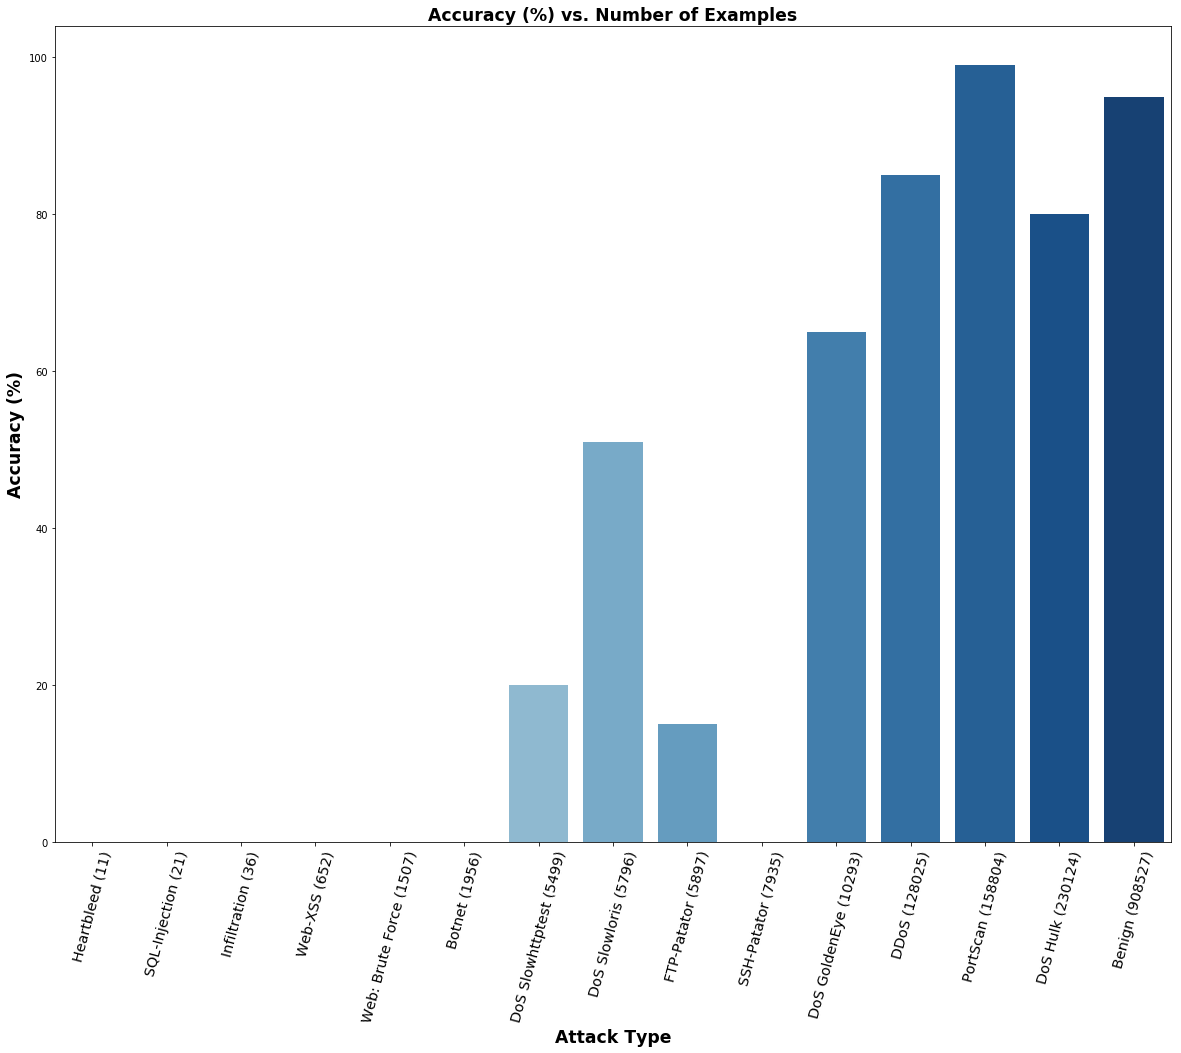

In [359]:
# sort, then reset index
# df = df_plot.sort_values('Recall', ascending = True).reset_index(drop=True)
plt.figure(figsize = (20,15))

acc = [0, 0, 0, 0, 0, 0, 20, 51, 15, 0, 65, 85, 99, 80, 95]

df_plot['Accuracy'] = acc 

ax = sns.barplot(x=df_plot.index, y=df_plot.Accuracy, palette=("Blues"))
ax.set_xlabel("Attack Type", weight='bold', size='xx-large')
ax.set_ylabel("Accuracy (%)", weight='bold', size='xx-large')
ax.set_title('Accuracy (%) vs. Number of Examples', weight='bold', size='xx-large')



# Use name column to label x ticks
_ = ax.set_xticklabels(df_plot.Label, rotation=75, size='x-large')


plt.savefig('Accuracy_vs_examples.png');

---

# Matrices

### Correlation

<Figure size 1440x1080 with 0 Axes>

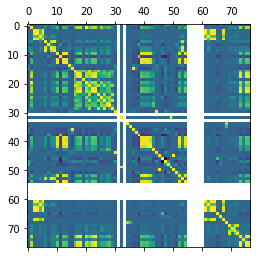

In [240]:
fig = plt.figure(figsize=(20,15))
plt.matshow(df_full.corr())
plt.show()

### Confusion

In [225]:
metrics.confusion_matrix(df_full_test_labels, log4_predict_1)

array([[220647,     31,     89,      7,    102,   1546,     87,    526,
             0,      1,      0,      0,      0,      7,   4090],
       [   608,    565,      0,      0,      0,      4,      0,      0,
             0,      0,      0,      0,      0,      0,      3],
       [     4,      0,   1581,      0,      0,      2,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [   399,      0,    108,    629,     23,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [    54,      0,      0,     71,    975,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [   141,      0,      0,      0,      0,  45785,      3,     96,
             0,      0,      0,      0,      0,      0,      0],
       [   258,      0,      0,      2,      1,      1,   1797,      0,
             0,      0,      0,      0,      0,      0,      0],
       [    36,      0,      0,      0,  

In [291]:
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    classes = ['Heartbleed', 
       'SQL-Injection', 
       'Infiltration', 
       'Web-XSS', 
       'Web: Brute Force', 
       'Botnet', 
       'DoS Slowhttptest',
       'DoS Slowloris', 
       'FTP-Patator', 
       'SSH-Patator', 
       'DoS GoldenEye',
       'DDoS', 
       'PortScan', 
       'DoS Hulk',
       'Benign']
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(20,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



fig = plt.figure(figsize=(20,15))


np.set_printoptions(precision=2)




fig.show()

C:\Anaconda\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<Figure size 1440x1080 with 0 Axes>

In [304]:
# classes = ['Heartbleed', 
#        'SQL-Injection', 
#        'Infiltration', 
#        'Web-XSS', 
#        'Web: Brute Force', 
#        'Botnet', 
#        'DoS Slowhttptest',
#        'DoS Slowloris', 
#        'FTP-Patator', 
#        'SSH-Patator', 
#        'DoS GoldenEye',
#        'DDoS', 
#        'PortScan', 
#        'DoS Hulk',
#        'Benign']
    



# # Plot non-normalized confusion matrix
# plot_confusion_matrix(df_full_test_labels, log4_predict_1, classes=df_full.Label.unique(),
#                       title='Confusion matrix, without normalization')

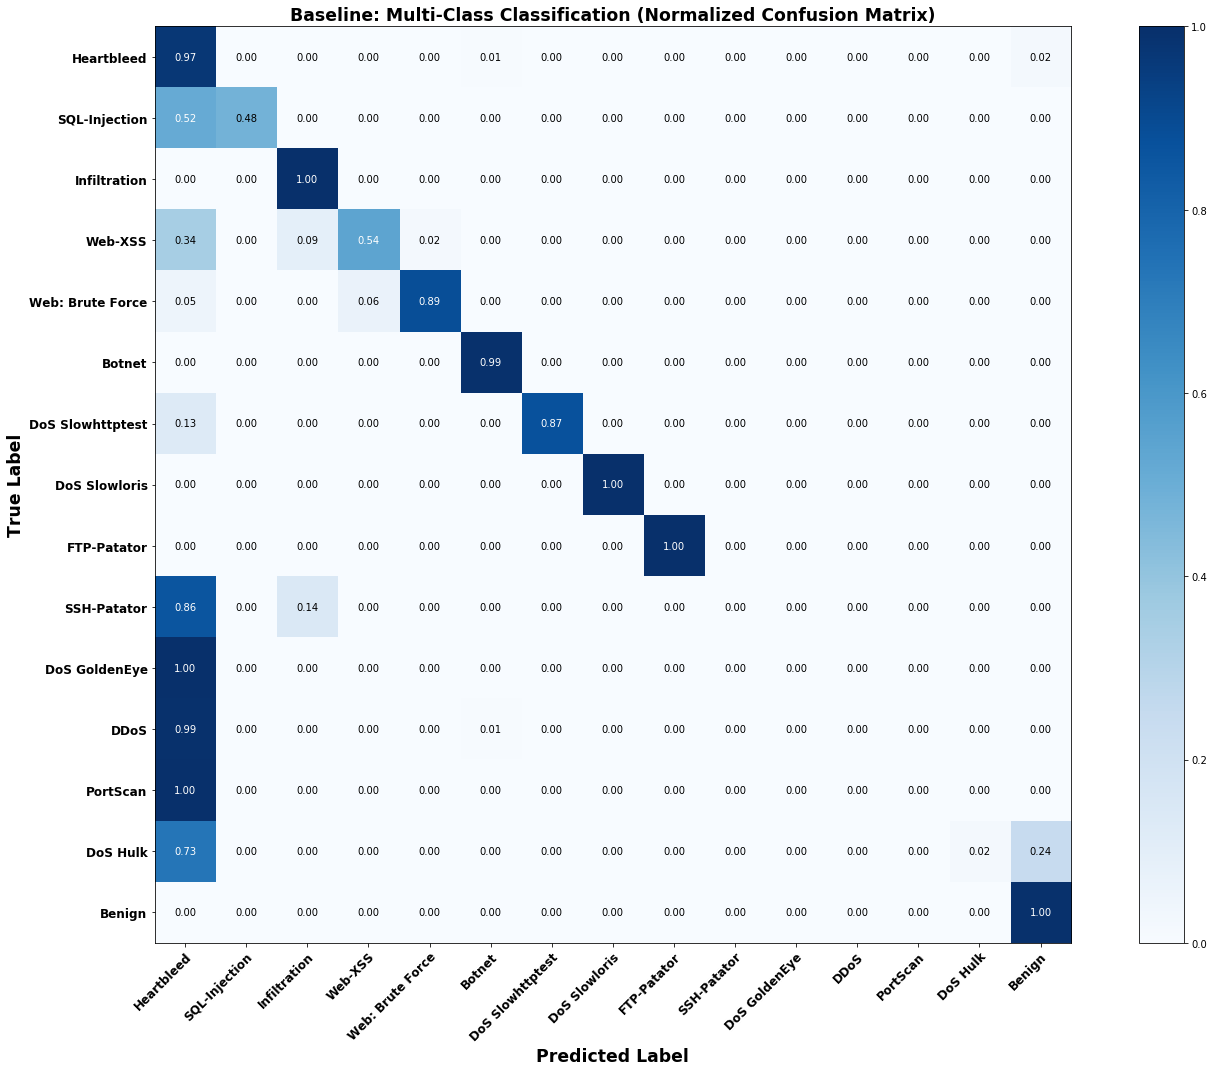

In [310]:
classes = ['Heartbleed', 
       'SQL-Injection', 
       'Infiltration', 
       'Web-XSS', 
       'Web: Brute Force', 
       'Botnet', 
       'DoS Slowhttptest',
       'DoS Slowloris', 
       'FTP-Patator', 
       'SSH-Patator', 
       'DoS GoldenEye',
       'DDoS', 
       'PortScan', 
       'DoS Hulk',
       'Benign']


normalize = True


cm = metrics.confusion_matrix(df_full_test_labels, log4_predict_1)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(20,15))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),

       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
#        title='Baseline: Multi-Class Classification (Normalized Confusion Matrix)',
#        ylabel='True label',
#        xlabel='Predicted label'
      )



ax.set_xlabel("Predicted Label", weight='bold', size='xx-large')
ax.set_xticklabels(classes, weight='bold', size='large')

ax.set_ylabel("True Label", weight='bold', size='xx-large')
ax.set_yticklabels(classes, weight='bold', size='large')

ax.set_title('Baseline: Multi-Class Classification (Normalized Confusion Matrix)', weight='bold', size='xx-large')




# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
   
    
    
# # Plot normalized confusion matrix
# plot_confusion_matrix(df_full_test_labels, log4_predict_1, classes=df_full.Label.unique(), normalize=True,
#                       title='Baseline: Multi-Class Classification (Normalized Confusion Matrix)')


plt.savefig('Baseline_M-C_CM.png');

# RBM Multi-Class CM

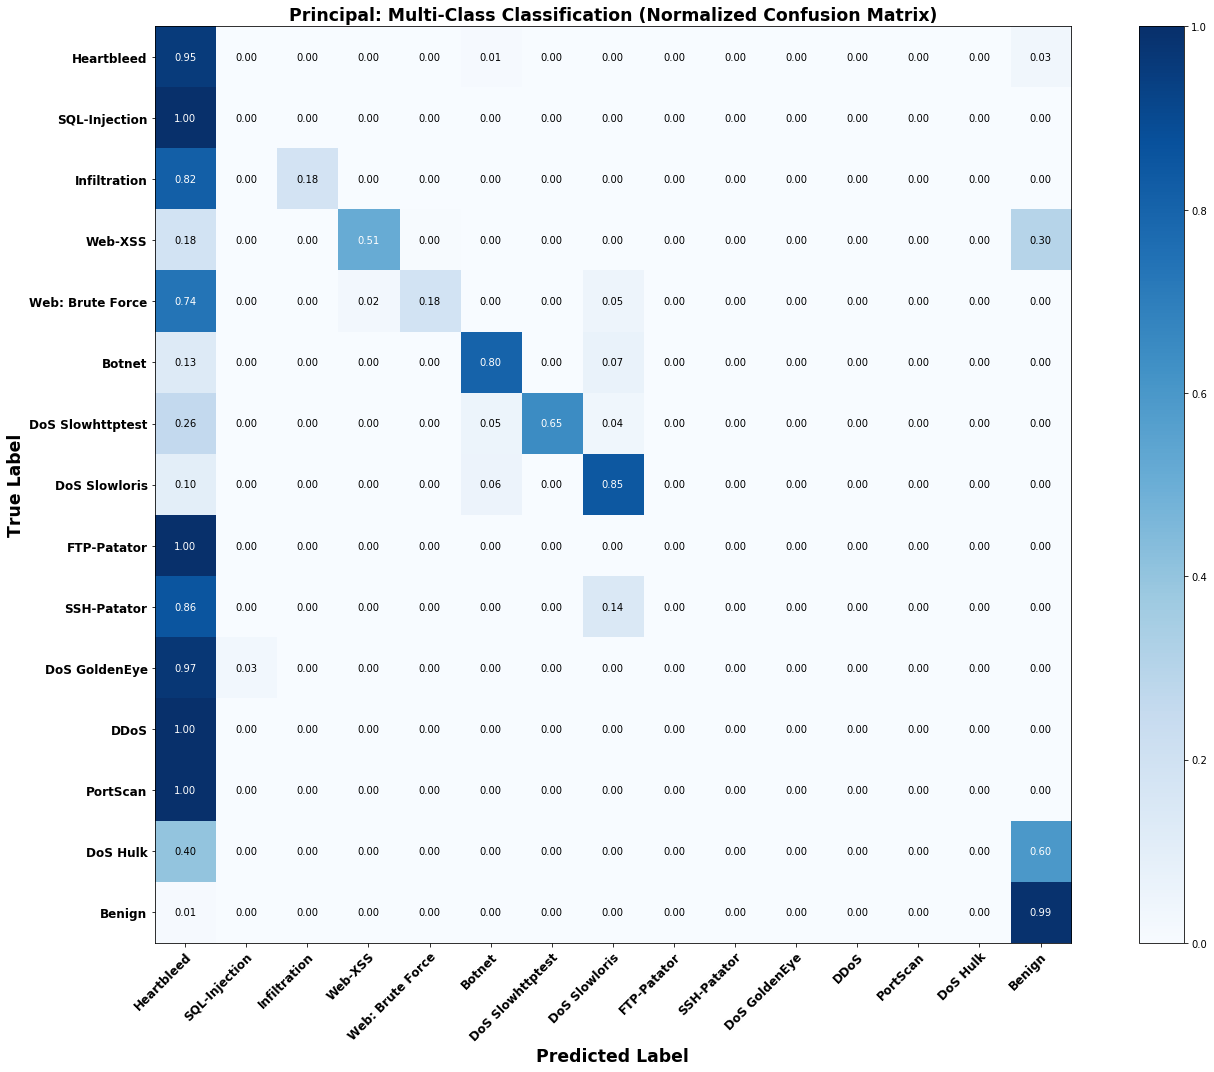

In [309]:
classes = ['Heartbleed', 
       'SQL-Injection', 
       'Infiltration', 
       'Web-XSS', 
       'Web: Brute Force', 
       'Botnet', 
       'DoS Slowhttptest',
       'DoS Slowloris', 
       'FTP-Patator', 
       'SSH-Patator', 
       'DoS GoldenEye',
       'DDoS', 
       'PortScan', 
       'DoS Hulk',
       'Benign']


normalize = True


cm = metrics.confusion_matrix(df_full_test_labels, rbm_predict4)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(20,15))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),

       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
#        title='Baseline: Multi-Class Classification (Normalized Confusion Matrix)',
#        ylabel='True label',
#        xlabel='Predicted label'
      )


ax.set_xlabel("Predicted Label", weight='bold', size='xx-large')
ax.set_xticklabels(classes, weight='bold', size='large')

ax.set_ylabel("True Label", weight='bold', size='xx-large')
ax.set_yticklabels(classes, weight='bold', size='large')

ax.set_title('Principal: Multi-Class Classification (Normalized Confusion Matrix)', weight='bold', size='xx-large')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
   
    
    
# # Plot normalized confusion matrix
# plot_confusion_matrix(df_full_test_labels, log4_predict_1, classes=df_full.Label.unique(), normalize=True,
#                       title='Baseline: Multi-Class Classification (Normalized Confusion Matrix)')

plt.savefig('Principal_M-C_CM.png');

In [303]:
# # Plot normalized confusion matrix
# plot_confusion_matrix(df_full_test_labels, rbm_predict4, classes=df_full.Label.unique(), normalize=True,
#                       title='Principal: Multi-Class Classification (Normalized Confusion Matrix)')



In [266]:
# Broken up into loose categories for now
df_packet_info = pd.DataFrame(df_clean[df_clean.columns[0:15]])
flow_statistics_info = pd.DataFrame(df_clean[df_clean.columns[16:31]])
packet_details_info = pd.DataFrame(df_clean[df_clean.columns[32:44]])
packet_type_info = pd.DataFrame(df_clean[df_clean.columns[45:53]])
packet_statistics_info = pd.DataFrame(df_clean[df_clean.columns[54:70]])
connection_stats_info = pd.DataFrame(df_clean[df_clean.columns[71:78]])


In [265]:

# df_packet_info.corr()
# flow_statistics_info.corr()
# packet_details_info.corr()
# packet_type_info.corr()
# packet_statistics_info.corr()
# connection_stats_info.corr()

AttributeError: 'AxesImage' object has no attribute 'set_xticklabels'

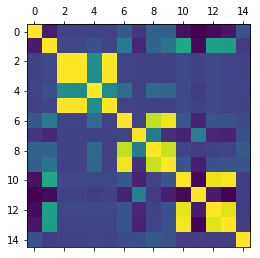

In [269]:
plt.matshow(df_packet_info.corr())

labels = df_packet_info.columns

ax.set_xticklabels(df_packet_info.columns, rotation=75, size='x-large')
ax.set_yticklabels(df_packet_info.columns, rotation=75, size='x-large')


ax.show()

In [353]:
labels_counts = pd.DataFrame(df_malicious.Label.value_counts())
labels_counts

,Label
DoS Hulk,230124
PortScan,158804
DDoS,128025
DoS GoldenEye,10293
FTP-Patator,7935
SSH-Patator,5897
DoS slowloris,5796
DoS Slowhttptest,5499
Bot,1956
Web Attack � Brute Force,1507


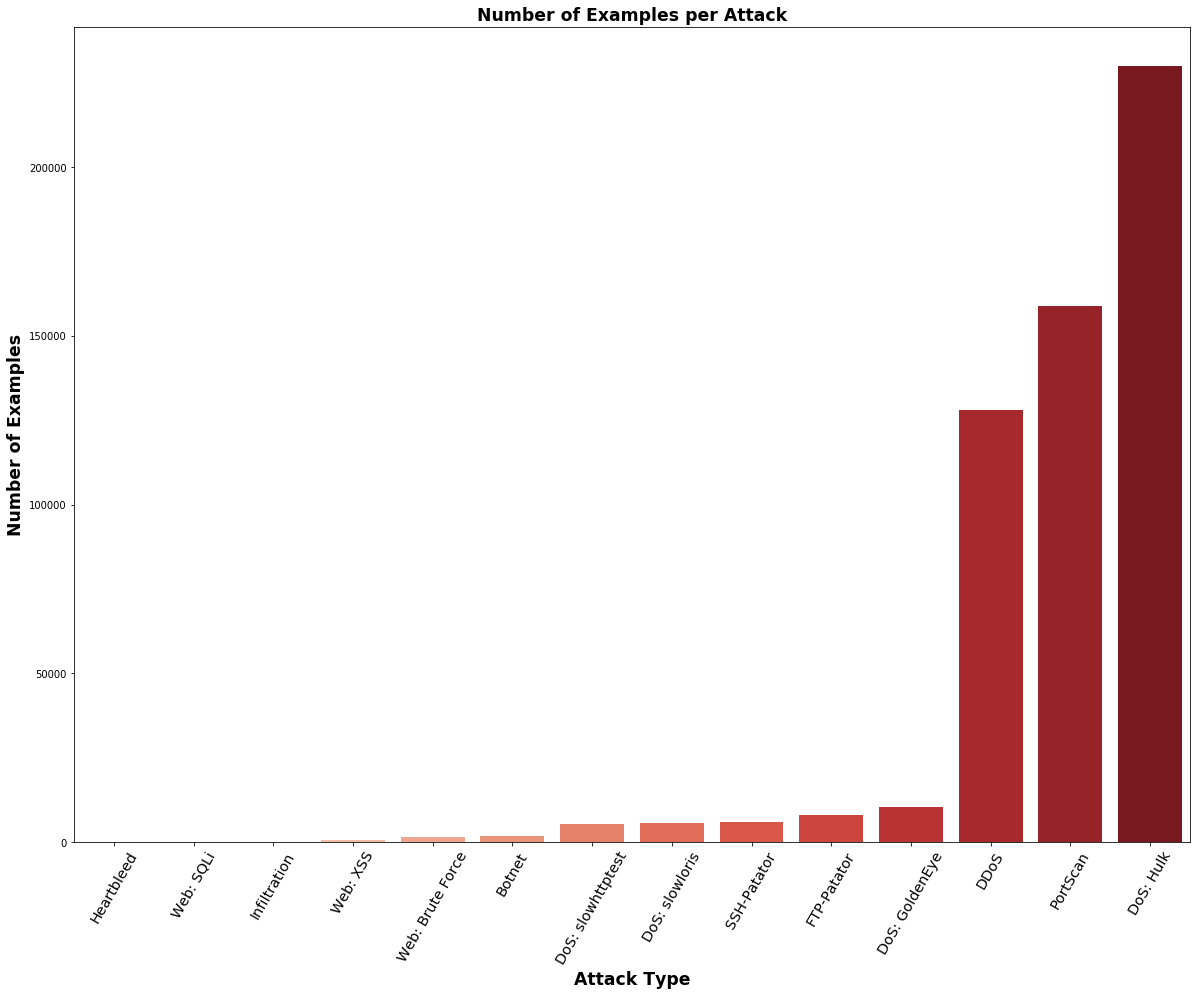

In [394]:
labels_counts = labels_counts.sort_values('Label', ascending = True).reset_index(drop=True)


plt.figure(figsize = (20,15))

ax = sns.barplot(x=labels_counts.index, y=labels_counts.Label, palette=("Reds"))
ax.set_xlabel("Attack Type", weight='bold', size='xx-large')
ax.set_ylabel("Number of Examples", weight='bold', size='xx-large')
ax.set_title('Number of Examples per Attack', weight='bold', size='xx-large')

l = ['Heartbleed', 'Web: SQLi', 'Infiltration', 'Web: XSS', 'Web: Brute Force', 'Botnet', 'DoS: slowhttptest', 'DoS: slowloris', 'SSH-Patator', 'FTP-Patator', 'DoS: GoldenEye', 'DDoS', 'PortScan', 'DoS: Hulk']

# Use name column to label x ticks
_ = ax.set_xticklabels(l, rotation=60, size='x-large')

# ax = .plot(kind='barh') # s is a Series (float) in [0,1]
# [ax.text(v, i, '{:.2f}%'.format(100*v)) for i, v in enumerate(labels_counts.Label)];


# plt.savefig('Accuracy_vs_examples.png');

In [428]:
legend = [
            "SSH-Patator",
            "FTP-Patator",
            "DoS slowloris",
            "DoS Slowhttptest",
            "DoS Hulk",
            "DoS GoldenEye",
            "DDoS",
            "Heartbleed",
            'Infiltration',
            "Web: Brute Force",
            "Web: XSS",
            "Web: SQL Injection",
            'Bot',
            'PortScan',
              ]


# labels_counts = labels_counts.sort_values('Label', ascending = True).reset_index(drop=True)
detections = pd.DataFrame(index = legend)
detections['Baseline'] = [48,100,54,89,99,87,100,100,0,0,0,0,3,100]
detections['Principal'] = [0,16,51,19,80,65,85,0,0,0,0,0,0,99]
detections

,Baseline,Principal
SSH-Patator,48,0
FTP-Patator,100,16
DoS slowloris,54,51
DoS Slowhttptest,89,19
DoS Hulk,99,80
DoS GoldenEye,87,65
DDoS,100,85
Heartbleed,100,0
Infiltration,0,0
Web: Brute Force,0,0


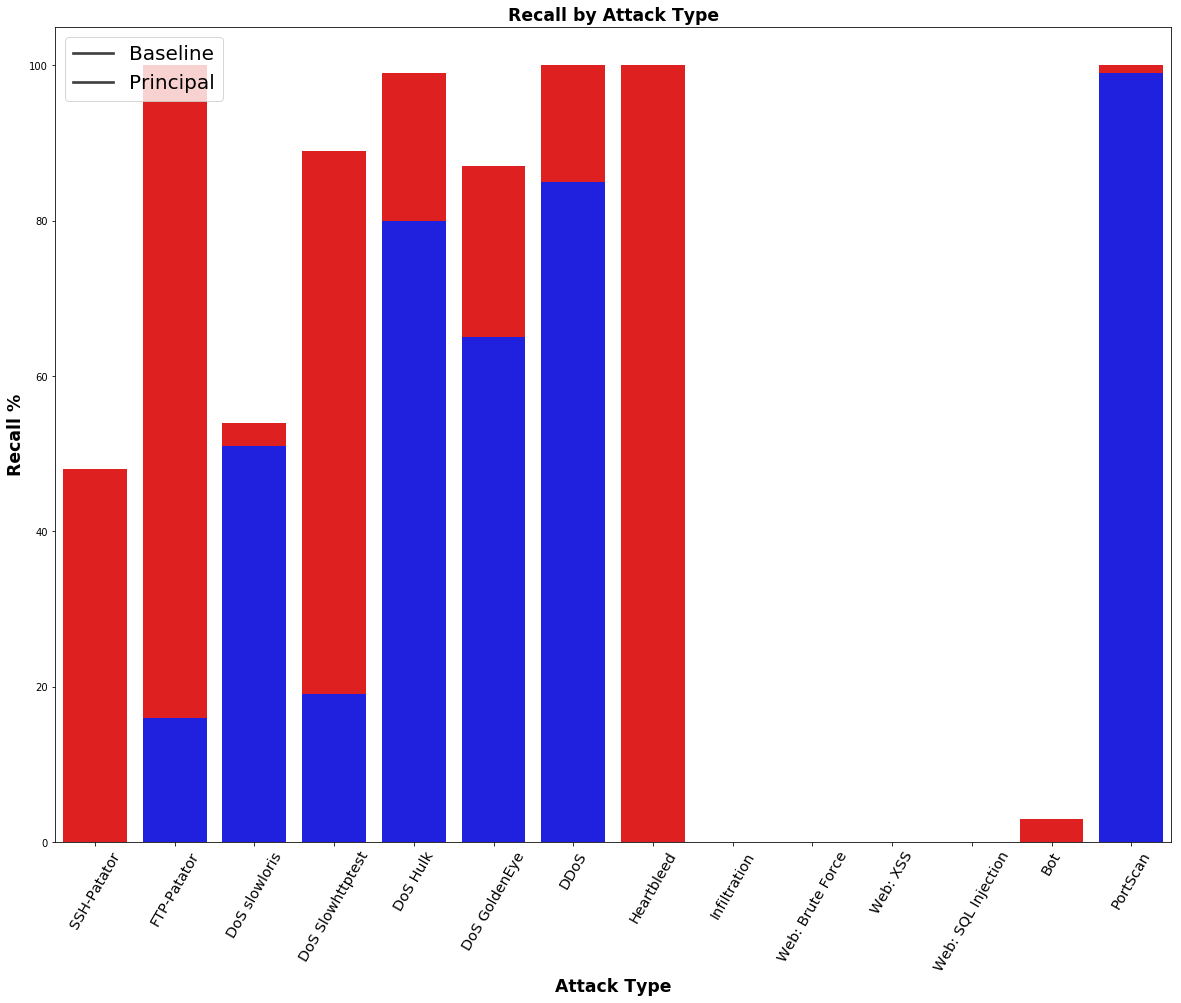

In [436]:
plt.figure(figsize = (20,15))

ax = sns.barplot(x=detections.index, y=detections.Baseline, color='r')
sns.barplot(x=detections.index, y=detections.Principal, color='b')

ax.set_xlabel("Attack Type", weight='bold', size='xx-large')
ax.set_ylabel("Recall %", weight='bold', size='xx-large')
ax.set_title('Recall by Attack Type', weight='bold', size='xx-large')

# Use name column to label x ticks
_ = ax.set_xticklabels(legend, rotation=60, size='x-large')


types = ['Baseline', 'Principal']
plt.legend(types)


# plt.savefig('Accuracy_vs_examples.png');

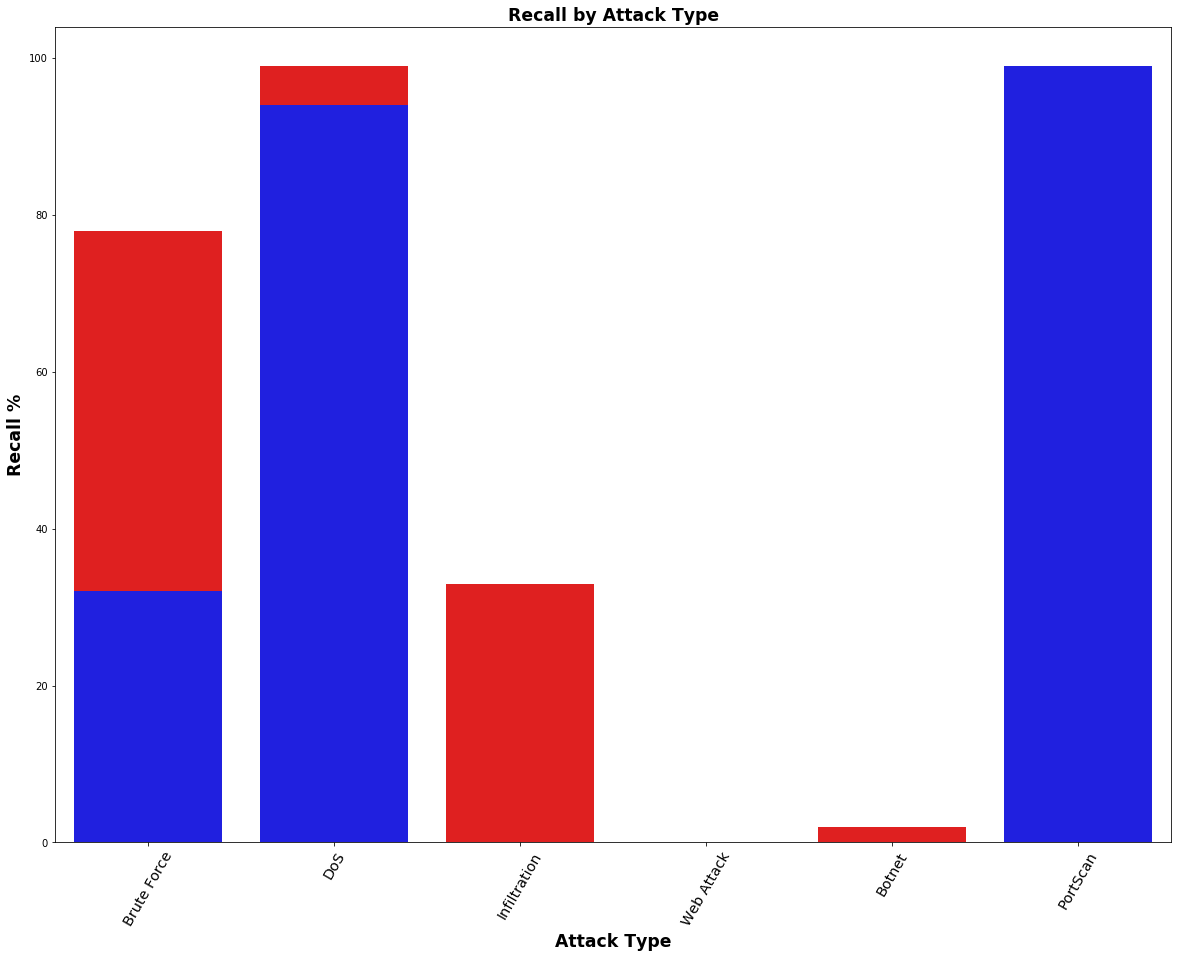

In [457]:
legend = [
            'Brute Force',
            "DoS",
            "Infiltration",
            'Web Attack',
            'Botnet',
            'PortScan',
              ]


# labels_counts = labels_counts.sort_values('Label', ascending = True).reset_index(drop=True)
detections = pd.DataFrame(index = legend)
detections['Baseline'] = [78, 99, 33, 0, 2, 99]
detections['Principal'] = [32, 94, 0, 0, 0, 99]
detections

plt.figure(figsize = (20,15))

ax = sns.barplot(x=detections.index, y=detections.Baseline, color='r')
sns.barplot(x=detections.index, y=detections.Principal, color='b')

ax.set_xlabel("Attack Type", weight='bold', size='xx-large')
ax.set_ylabel("Recall %", weight='bold', size='xx-large')
ax.set_title('Recall by Attack Type', weight='bold', size='xx-large')

# Use name column to label x ticks
_ = ax.set_xticklabels(legend, rotation=60, size='x-large')


# types = ['Baseline', 'Principal']
# plt.legend(types)


# plt.savefig('Accuracy_vs_examples.png');

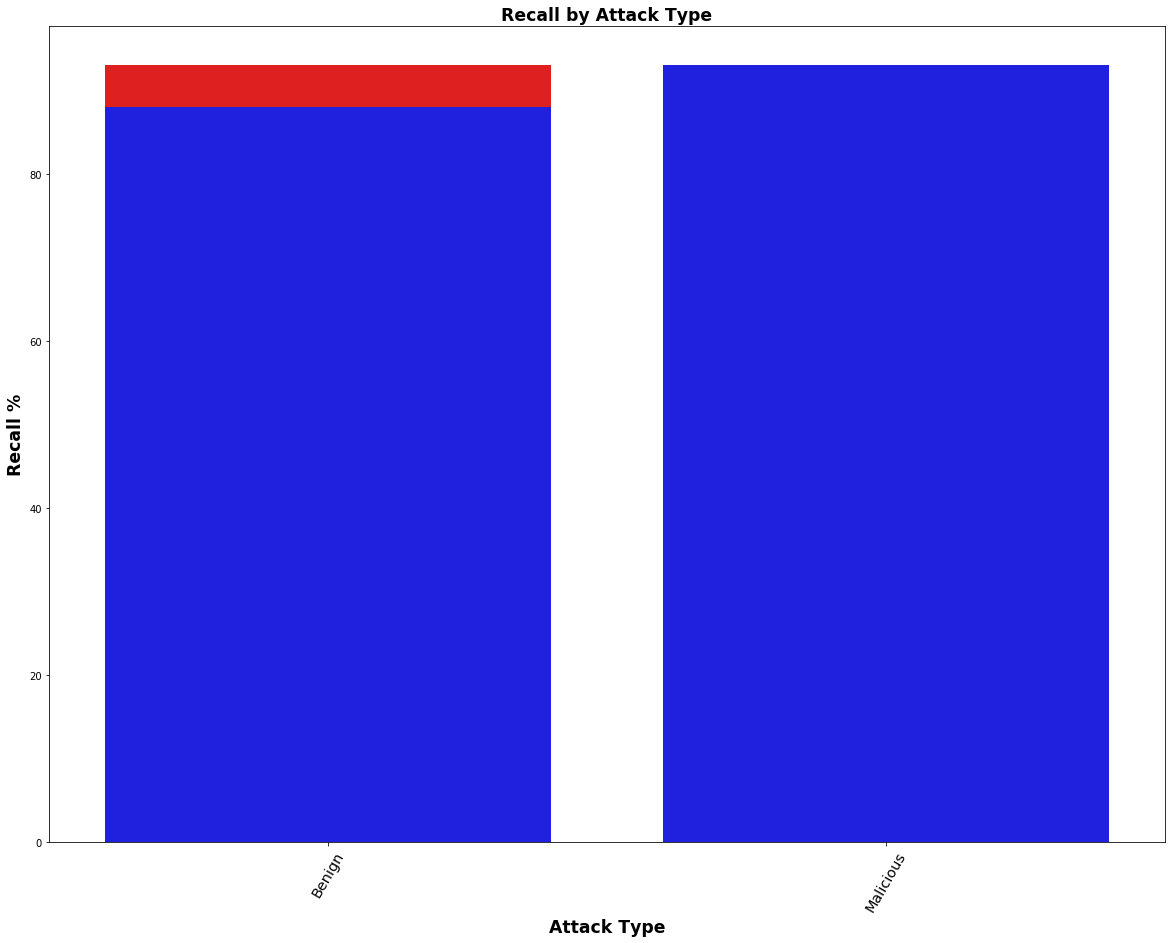

In [461]:
legend = [
            'Benign',
            'Malicious',
              ]


# labels_counts = labels_counts.sort_values('Label', ascending = True).reset_index(drop=True)
detections = pd.DataFrame(index = legend)
detections['Baseline'] = [93, 93]
detections['Principal'] = [88, 93]
detections

plt.figure(figsize = (20,15))

ax = sns.barplot(x=detections.index, y=detections.Baseline, color='r')
sns.barplot(x=detections.index, y=detections.Principal, color='b')

ax.set_xlabel("Attack Type", weight='bold', size='xx-large')
ax.set_ylabel("Recall %", weight='bold', size='xx-large')
ax.set_title('Recall by Attack Type', weight='bold', size='xx-large')

# Use name column to label x ticks
_ = ax.set_xticklabels(legend, rotation=60, size='x-large')


# types = ['Baseline', 'Principal']
# plt.legend(types)


# plt.savefig('Accuracy_vs_examples.png');

---
---
---

# Autoencoders

In [31]:
import tensorflow as tf

n_inputs = 77
n_hidden = 5
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs -X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()



In [32]:
X_train, X_test = df_bin_train, df_bin_test

n_iterations = 1000
codings = hidden 

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

KeyboardInterrupt: 